### CNN model
#### using the convolutional neural network architecture to predict litter moisture. First, we trained the model with manually selected hyperparameters, then using the Optun framework, we searched for hyperparameters to find the best perforating architecture.

In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import optuna
import tensorflow as tf
from litter import WindowGenerator
from matplotlib.gridspec import GridSpec
from optuna.integration import TFKerasPruningCallback
from scipy.stats import gaussian_kde

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use("bmh")

In [4]:
# WindowGenerator params
DATA_PATH = "../stations"
SCALING = "standarization"  # 'normalization'
GAP_STRATEGY = "linear"
FIRST_SEASON = 2015
FIRST_VAL_SEASON = 2021
FIRST_TEST_SEASON = 2022
LAST_TEST_SEASON = 2022

# data generator params
FEATURES = [
    "air_temperature_50cm",
    "air_temperature_200cm",
    "air_humidity_50cm",
    "air_humidity_200cm",
    "wind_x",
    "wind_y",
    "max_wind_x",
    "max_wind_y",
    "temporary_rainfall",
    "total_precipitation",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]
DATA_FORMAT = "channels_last"
INTERVALS = [3, 6, 6 * 2, 6 * 4, 6 * 24, 6 * 24 * 12]
BASE_SEQ_LEN = 30
OTHER_SEQ_LEN = [30, 30, 30, 30, 30, 30]
INCLUDE_COORDS = True
USE_PREVIOUS_Y = True
REPLACE = False

# training params
BATCH_SIZE = 32

In [5]:
wg = WindowGenerator(
    data_path=DATA_PATH,
    scaling=SCALING,
    gap_strategy=GAP_STRATEGY,
    first_train_season=FIRST_SEASON,
    first_val_season=FIRST_VAL_SEASON,
    first_test_season=FIRST_TEST_SEASON,
    last_test_season=LAST_TEST_SEASON,
)

In [6]:
(train_x, train_y), (val_x, val_y), (test_x, test_y), length_stats = wg.get_data(
    batch_size=BATCH_SIZE,
    data_format=DATA_FORMAT,
    intervals=INTERVALS,
    base_seq_len=BASE_SEQ_LEN,
    other_seq_len=OTHER_SEQ_LEN,
    features_cols=FEATURES,
    include_coords=INCLUDE_COORDS,
    use_previous_y=USE_PREVIOUS_Y,
    replace=REPLACE,
    train_generator=False,
    val_generator=False,
    test_generator=False,
)

data format: channels_last
641
641 641 641
370
370 370 370
1586
1586 1586 1586
1324
1324 1324 1324
1673
1673 1673 1673
1279
1279 1279 1279
711
711 711 711
431
431 431 431
266
266 266 266
219
219 219 219
1945
1945 1945 1945
1209
1209 1209 1209
1407
1407 1407 1407
966
966 966 966
1033
1033 1033 1033
0
0 0 0
879
879 879 879
505
505 505 505
1197
1197 1197 1197
750
750 750 750
868
868 868 868
608
608 608 608
875
875 875 875
550
550 550 550
1617
1617 1617 1617
1126
1126 1126 1126
2035
2035 2035 2035
1673
1673 1673 1673
1993
1993 1993 1993
1225
1225 1225 1225
1968
1968 1968 1968
1240
1240 1240 1240
1107
1107 1107 1107
767
767 767 767
2006
2006 2006 2006
1409
1409 1409 1409
1834
1834 1834 1834
1074
1074 1074 1074
165
165 165 165
69
69 69 69
1178
1178 1178 1178
532
532 532 532
1603
1603 1603 1603
1028
1028 1028 1028
1879
1879 1879 1879
907
907 907 907
1327
1327 1327 1327
766
766 766 766
1774
1774 1774 1774
1091
1091 1091 1091
1889
1889 1889 1889
1270
1270 1270 1270
2009
2009 2009 2009
1589
1589

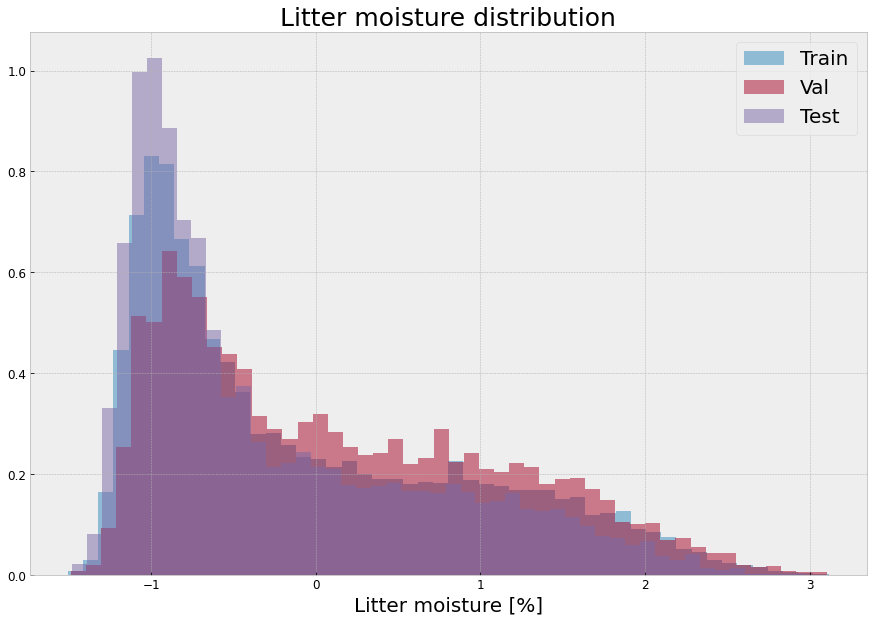

In [7]:
fig, ax = plt.subplots()


ax.hist(train_y, bins=50, density=True, label="Train", alpha=0.5)
ax.hist(val_y, bins=50, density=True, label="Val", alpha=0.5)
ax.hist(test_y, bins=50, density=True, label="Test", alpha=0.5)

plt.title("Litter moisture distribution", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Litter moisture [%]", fontsize=20)
plt.legend(fontsize=20)

plt.savefig("litter_moisture_norm.svg")

In [8]:
if SCALING == "normalization":
    train_y = (
        (wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]) * train_y
    ) + wg.train_min["litter_moisture"]
    val_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_y + wg.train_min["litter_moisture"]
    test_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_y + wg.train_min["litter_moisture"]

    y_morning_train = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * train_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_val = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_test = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_x[0][:, 0] + wg.train_min["litter_moisture"]

elif SCALING == "standarization":
    train_y = (
        train_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    )
    val_y = val_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    test_y = test_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]

    y_morning_train = (
        train_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_val = (
        val_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_test = (
        test_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )

else:
    y_morning_train = train_x[0][:, 0]
    y_morning_val = val_x[0][:, 0]
    y_morning_test = test_x[0][:, 0]

pct_change_train = (train_y - y_morning_train) / y_morning_train * 100
pct_change_val = (val_y - y_morning_val) / y_morning_val * 100
pct_change_test = (test_y - y_morning_test) / y_morning_test * 100

pct_change_mean = pct_change_train.mean()
pct_change_std = pct_change_train.std()

pct_change_standarized_train = (pct_change_train - pct_change_mean) / pct_change_std
pct_change_standarized_val = (pct_change_val - pct_change_mean) / pct_change_std
pct_change_standarized_test = (pct_change_test - pct_change_mean) / pct_change_std

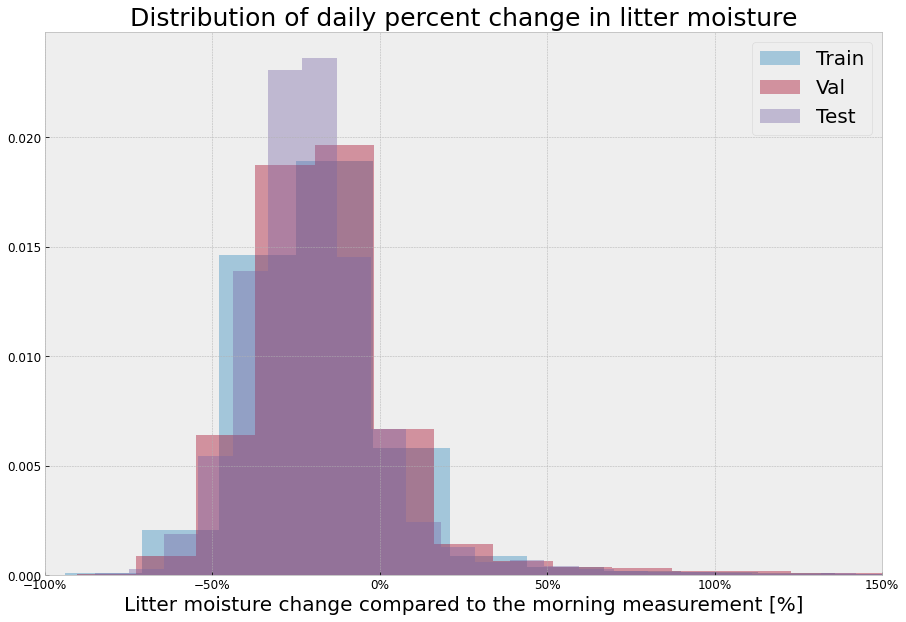

In [9]:
fig, ax = plt.subplots()


ax.hist(pct_change_train, bins=50, density=True, label="Train", alpha=0.4)
ax.hist(pct_change_val, bins=50, density=True, label="Val", alpha=0.4)
ax.hist(pct_change_test, bins=50, density=True, label="Test", alpha=0.4)

plt.xlim([-100, 150])
plt.title("Distribution of daily percent change in litter moisture", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax.set_xlabel(
    "Litter moisture change compared to the morning measurement [%]", fontsize=20
)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_change.svg")

In [ ]:
def get_conv_model():

    if OTHER_SEQ_LEN:
        sequences_n = OTHER_SEQ_LEN
    else:
        sequences_n = [BASE_SEQ_LEN for _ in range(INTERVALS)]

    features_n = len(FEATURES)
    sequence_inputs = [
        tf.keras.Input(shape=(seq_n, features_n), name=f"seq_input_{str(i)}")
        for i, seq_n in enumerate(sequences_n)
    ]
    dense_inputs_len = 1 if USE_PREVIOUS_Y else 0
    dense_inputs_len += 2 if INCLUDE_COORDS else 0
    if dense_inputs_len:
        dense_inputs = tf.keras.Input(shape=(dense_inputs_len), name="dense_input")
    else:
        dense_inputs = None

    conv_blocks = []
    for i, sequence_input in enumerate(sequence_inputs):

        conv_1 = tf.keras.layers.Conv1D(
            256, 3, padding="same", activation="relu", name=f"conc_{str(i)}_1"
        )
        conv_2 = tf.keras.layers.Conv1D(
            256, 3, padding="same", activation="relu", name=f"conc_{str(i)}_2"
        )
        conv_3 = tf.keras.layers.Conv1D(
            128, 3, padding="same", activation="relu", name=f"conv_{str(i)}_3"
        )
        conv_4 = tf.keras.layers.Conv1D(
            128, 3, padding="same", activation="relu", name=f"conv_{str(i)}_4"
        )
        conv_5 = tf.keras.layers.Conv1D(
            64, 3, padding="same", activation="relu", name=f"conv_{str(i)}_5"
        )
        conv_6 = tf.keras.layers.Conv1D(
            64, 3, padding="same", activation="relu", name=f"conv_{str(i)}_6"
        )

        x = conv_1(sequence_input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = conv_2(x)
        x = tf.keras.layers.MaxPool1D()(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = conv_3(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = conv_4(x)
        x = tf.keras.layers.MaxPool1D()(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = conv_5(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = conv_6(x)

        x = tf.keras.layers.Flatten()(x)

        conv_blocks.append(x)

    # concatenate all lstm_blocks, and optionally dense data
    if dense_inputs is not None:
        concat = tf.keras.layers.concatenate(
            [dense_inputs, *conv_blocks], name="concatenate"
        )
    else:
        concat = tf.keras.layers.concatenate(conv_blocks, name="concatenate")

    concat = tf.keras.layers.BatchNormalization()(concat)

    dense1 = tf.keras.layers.Dense(256, activation="relu")(concat)
    batchnorm1 = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(64, activation="relu")(batchnorm1)
    batchnorm2 = tf.keras.layers.BatchNormalization()(dense2)

    outputs = tf.keras.layers.Dense(1)(batchnorm2)
    if dense_inputs is not None:
        model = tf.keras.models.Model(
            inputs=[dense_inputs, *sequence_inputs], outputs=outputs
        )
    else:
        model = tf.keras.models.Model(inputs=sequence_inputs, outputs=outputs)
    return model

In [ ]:
model = get_conv_model()
model.summary()

2022-10-01 12:55:52.736990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 12:55:52.739770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 12:55:52.743390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 12:55:52.746011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input_0 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_1 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_2 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_3 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                              

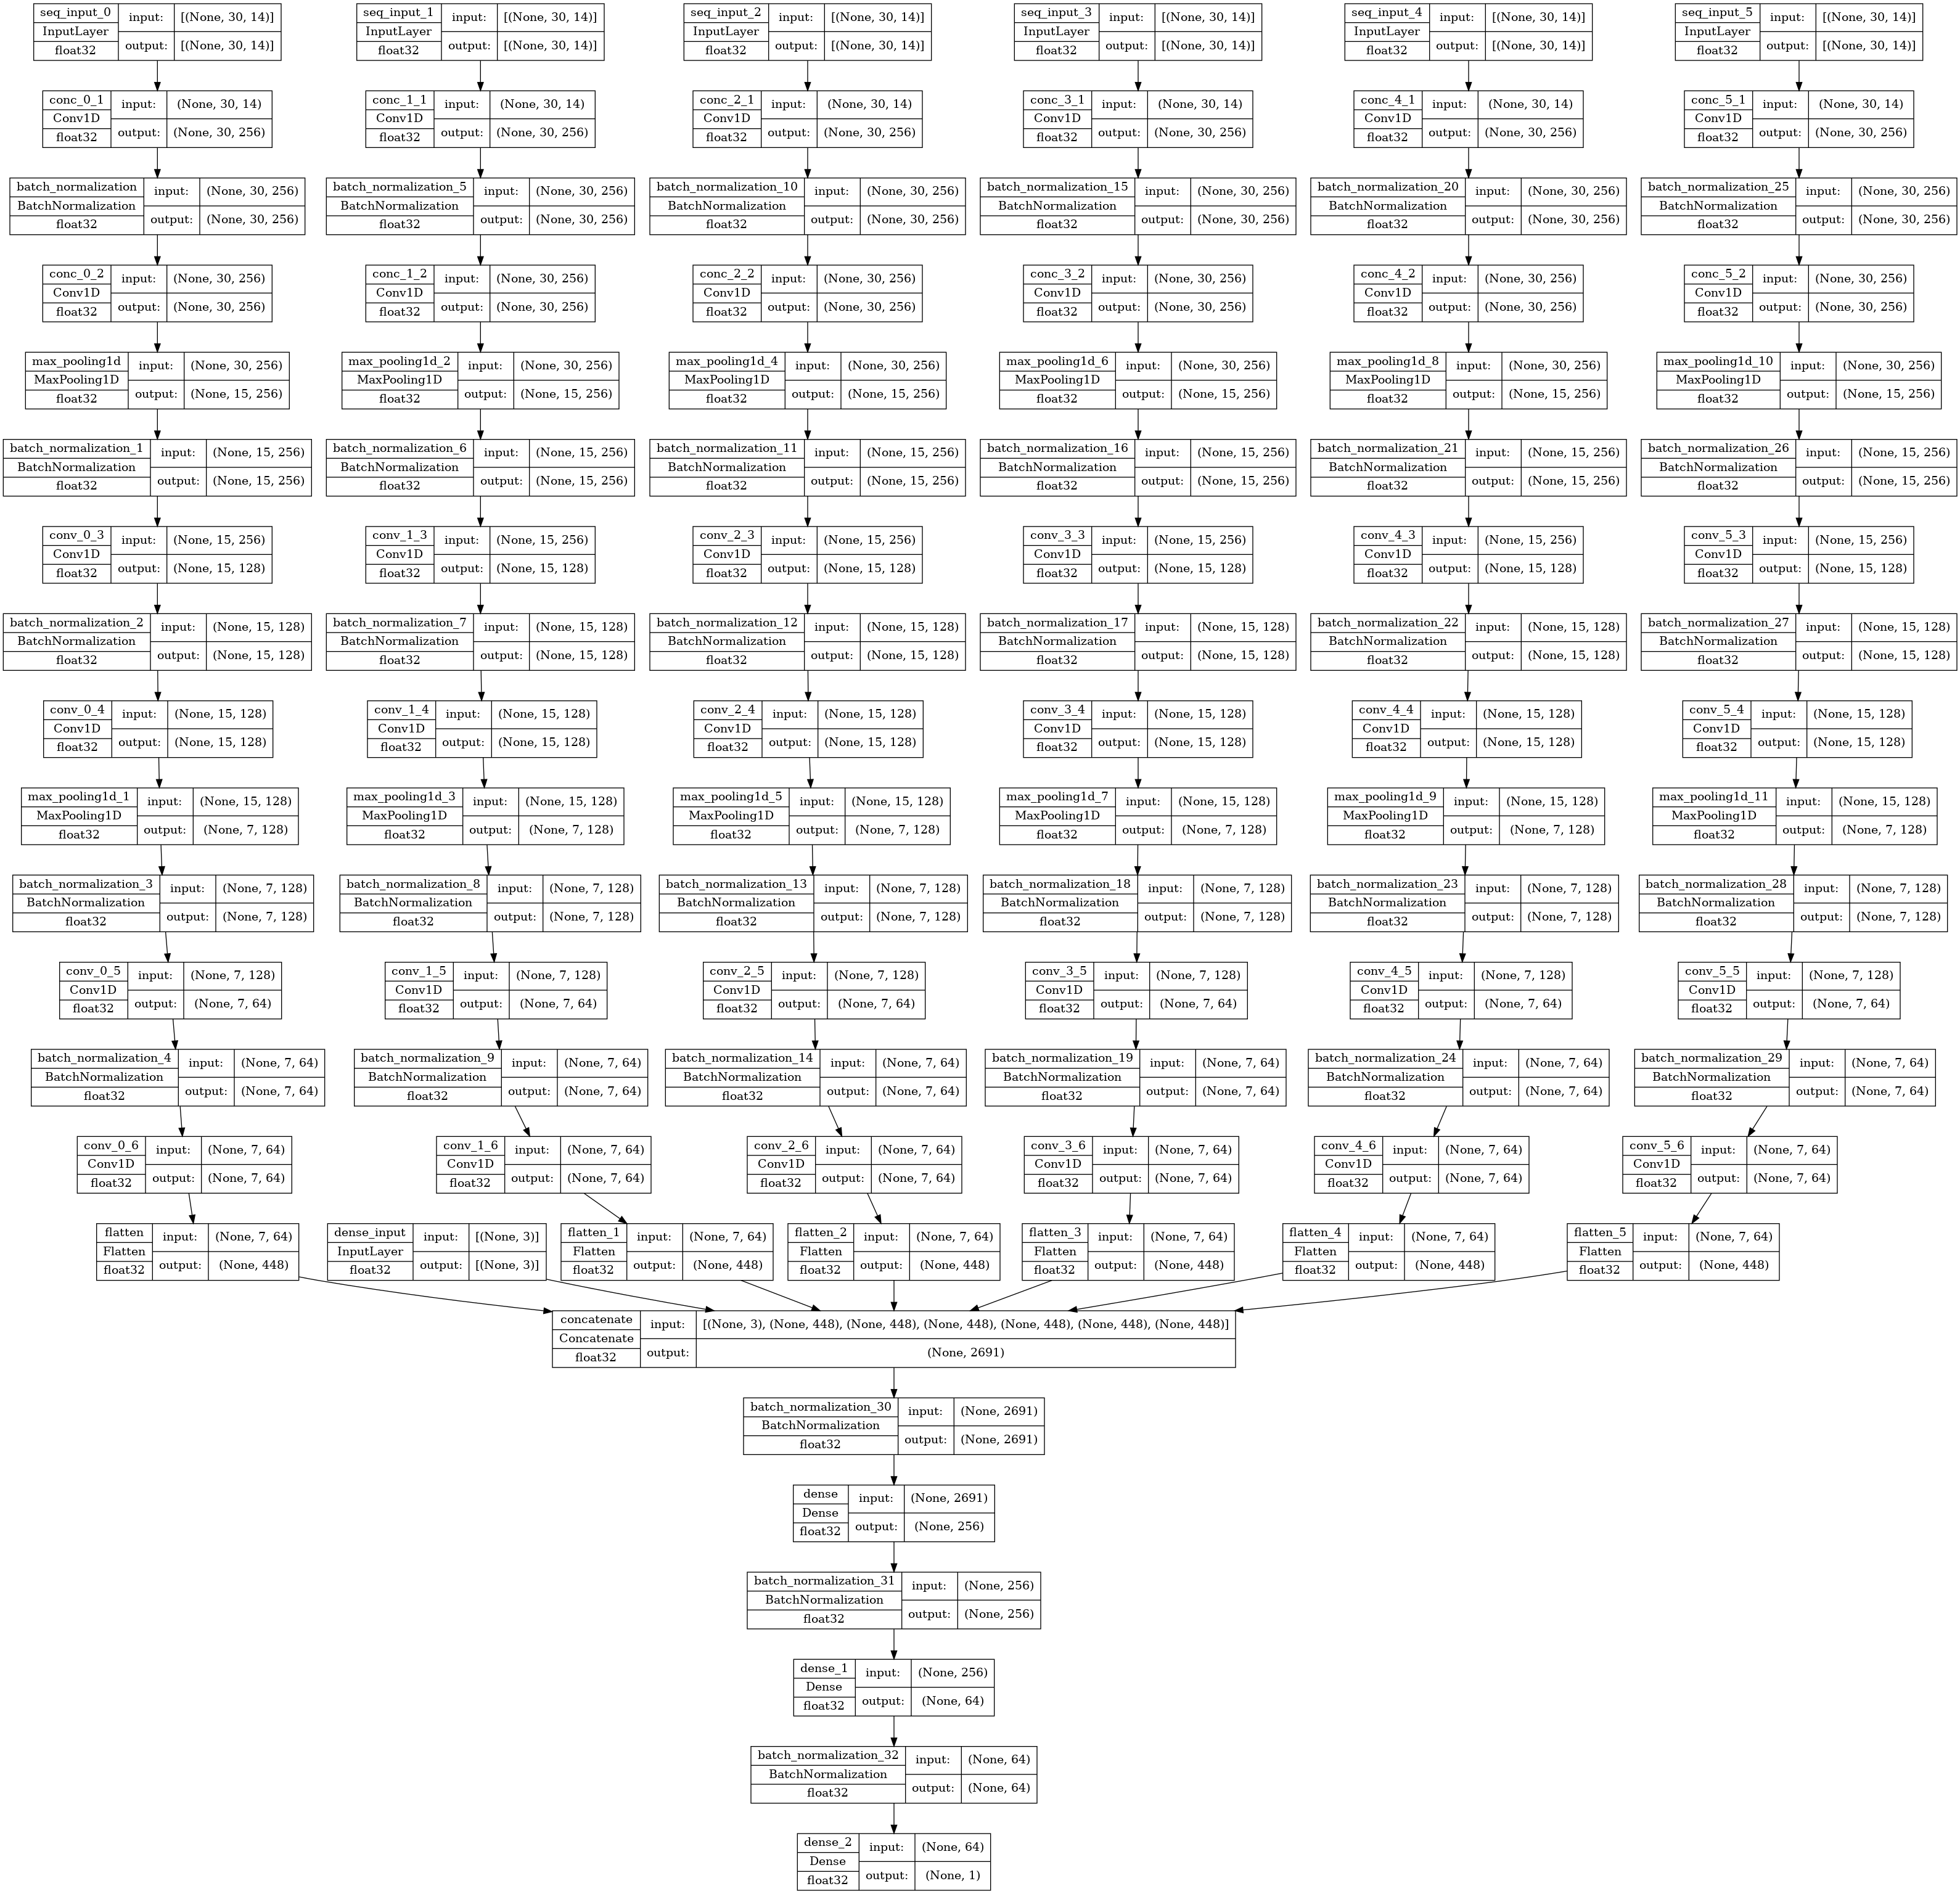

In [ ]:
tf.keras.utils.plot_model(
    model,
    "model.png",
    show_shapes=True,
    show_dtype=True,
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
    loss=tf.keras.losses.Huber(0.65),
)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
    x=train_x,
    y=pct_change_standarized_train,
    epochs=500,
    validation_data=(val_x, pct_change_standarized_val),
    callbacks=[es],
)

Epoch 1/500


2022-10-01 12:56:08.972639: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


1904/1904 [==============================] - 88s 38ms/step - loss: 0.1917 - val_loss: 0.1781
Epoch 2/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1545 - val_loss: 0.1697
Epoch 3/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1474 - val_loss: 0.1623
Epoch 4/500
1904/1904 [==============================] - 71s 38ms/step - loss: 0.1425 - val_loss: 0.1620
Epoch 5/500
1904/1904 [==============================] - 72s 38ms/step - loss: 0.1374 - val_loss: 0.1669
Epoch 6/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1324 - val_loss: 0.1598
Epoch 7/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1283 - val_loss: 0.1588
Epoch 8/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1231 - val_loss: 0.1564
Epoch 9/500
1904/1904 [==============================] - 73s 39ms/step - loss: 0.1198 - val_loss: 0.1526
Epoch 10/500
1904/1904 [==============================] - 72s 38ms/

In [ ]:
test_loss = model.evaluate(test_x, pct_change_standarized_test)
print(f"test loss: {test_loss}")
test_predictions = model.predict(test_x).flatten()

272/272 [==============================] - 2s 9ms/step - loss: 0.1425
test loss: 0.1424882709980011
272/272 [==============================] - 3s 8ms/step


0.689526544592388


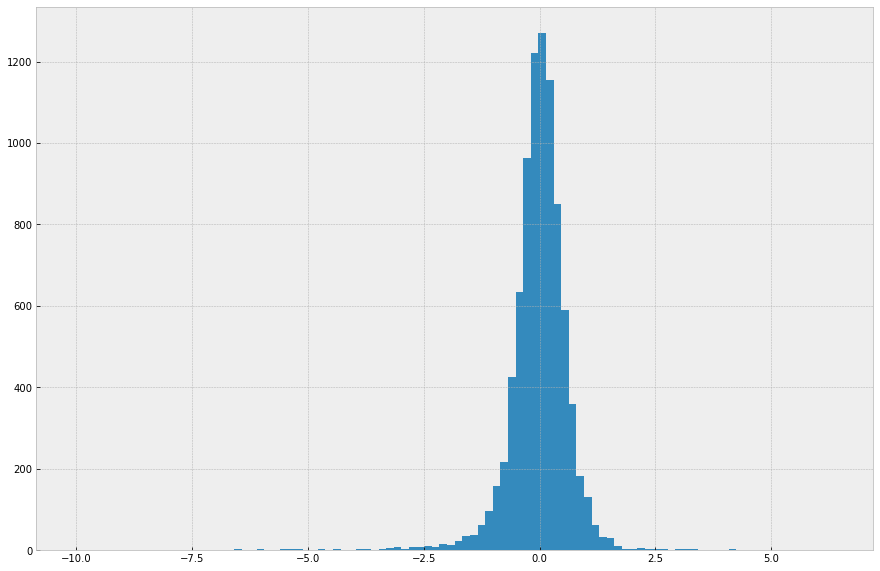

In [ ]:
delta = test_predictions - pct_change_standarized_test
print(delta.std())
_ = plt.hist(delta, bins=100)

In [ ]:
pct_change_predicted = test_predictions * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.5012548492654214 5.3335238565574725 16.690984674374988 11.698383230336043


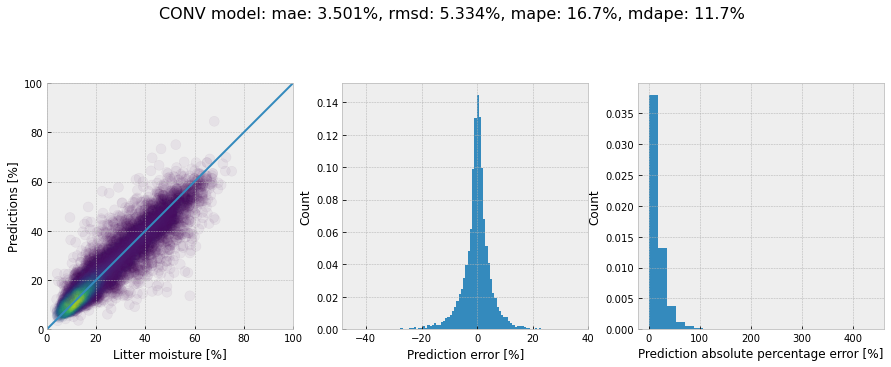

In [ ]:
# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"CONV model: mae: {round(mae, 3)}%, rmsd: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.05)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=100, density=True)
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)

error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=25, density=True)
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)

plt.savefig("results_error_show_conv2.svg")

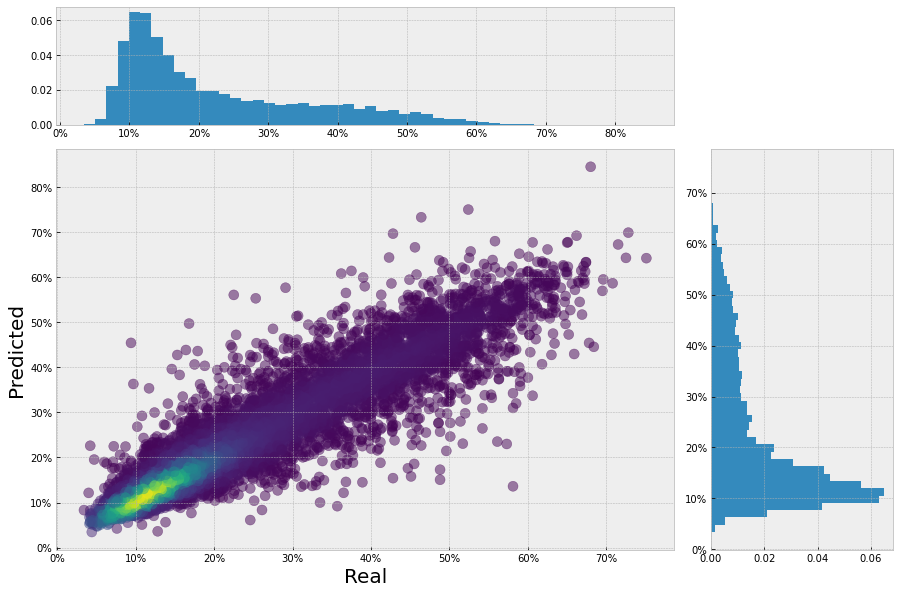

<Figure size 1080x720 with 0 Axes>

In [ ]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(y_real, y_pred, c=z, s=100, alpha=0.5)
ax_hist_x.hist(y_real, orientation="horizontal", bins=50, density=True)
ax_hist_y.hist(y_pred, bins=50, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_xlabel("Real", fontsize=20)
ax_scatter.set_ylabel("Predicted", fontsize=20)
plt.show()

plt.savefig("results_boundary_distribution.svg")

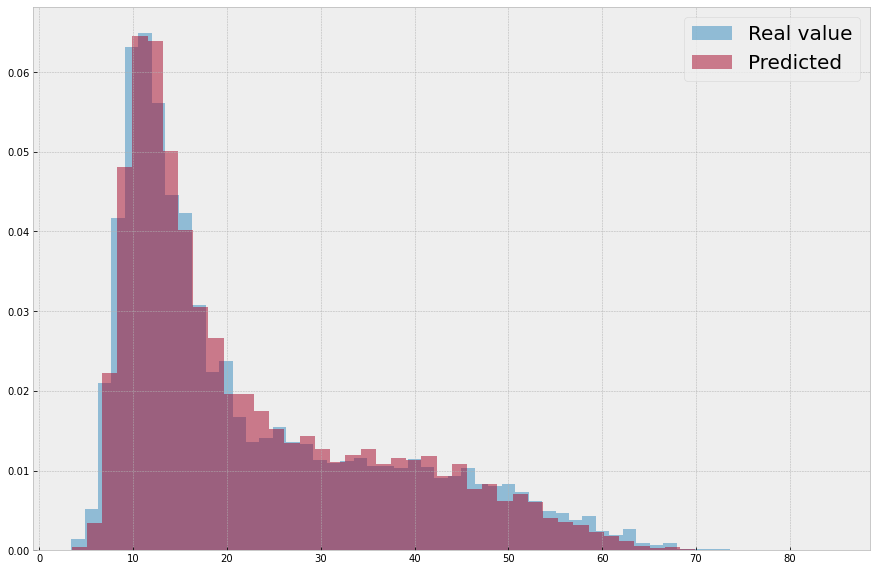

In [ ]:
_ = plt.hist(y_real, bins=50, density=True, alpha=0.5, label="Real value")
_ = plt.hist(y_pred, bins=50, density=True, alpha=0.5, label="Predicted")
plt.legend(fontsize=20)

plt.savefig("results_distribution_conv.svg")

In [ ]:
tf.keras.models.save_model(model, "best_custom_conv_pct_std")

In [ ]:
def create_model(trial):

    if OTHER_SEQ_LEN:
        sequences_n = OTHER_SEQ_LEN
    else:
        sequences_n = [BASE_SEQ_LEN for _ in range(INTERVALS)]

    features_n = len(FEATURES)
    sequence_inputs = [
        tf.keras.Input(shape=(seq_n, features_n), name=f"seq_input_{str(i)}")
        for i, seq_n in enumerate(sequences_n)
    ]
    dense_inputs_len = 1 if USE_PREVIOUS_Y else 0
    dense_inputs_len += 2 if INCLUDE_COORDS else 0
    if dense_inputs_len:
        dense_inputs = tf.keras.Input(shape=(dense_inputs_len), name="dense_input")
    else:
        dense_inputs = None

    # We optimize the numbers of layers, their units, dropout ratio and weight decay parameter.
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 4)
    n_dense_layers = trial.suggest_int("n_dense_layers", 0, 4)

    conv_blocks = []
    for i, sequence_input in enumerate(sequence_inputs):
        x = sequence_input
        for j in range(n_conv_layers):

            num_filters_1 = trial.suggest_categorical(
                "n_units_conv1_{}_{}".format(i, j), [32, 64, 128, 256]
            )
            num_filters_2 = trial.suggest_categorical(
                "n_units_conv1_{}_{}".format(i, j), [32, 64, 128, 256]
            )

            x = tf.keras.layers.Conv1D(
                num_filters_1,
                3,
                padding="same",
                activation="relu",
                name=f"conv_{str(i)}_{str(j)}_1",
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Conv1D(
                num_filters_2,
                3,
                padding="same",
                activation="relu",
                name=f"conv_{str(i)}_{str(j)}_2",
            )(x)
            x = tf.keras.layers.MaxPool1D()(x)
            x = tf.keras.layers.BatchNormalization()(x)

            if j == n_conv_layers - 1:
                x = tf.keras.layers.Flatten()(x)

    conv_blocks.append(x)

    # concatenate all conv_blocks, and optionally dense data
    if dense_inputs is not None:
        x = tf.keras.layers.concatenate(
            [dense_inputs, *conv_blocks], name="concatenate"
        )
    else:
        x = tf.keras.layers.concatenate(conv_blocks, name="concatenate")

    for i in range(n_dense_layers):
        num_hidden = trial.suggest_categorical("n_units_l{}".format(i), [32, 64, 128])
        dense = tf.keras.layers.Dense(
            num_hidden,
            activation="relu",
        )
        x = dense(x)
        x = tf.keras.layers.BatchNormalization()(x)

    if not n_dense_layers:
        x = tf.keras.layers.BatchNormalization()(x)

    outputs = tf.keras.layers.Dense(1)(x)
    if dense_inputs is not None:
        model = tf.keras.models.Model(
            inputs=[dense_inputs, *sequence_inputs], outputs=outputs
        )
    else:
        model = tf.keras.models.Model(inputs=sequence_inputs, outputs=outputs)
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float(
            "rmsprop_momentum", 5 * 1e-5, 1e-1, log=True
        )
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float(
            "adam_learning_rate", 5 * 1e-5, 1e-1, log=True
        )
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float(
            "sgd_opt_momentum", 5 * 1e-5, 1e-1, log=True
        )

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [ ]:
# TODO
# The method of saving to file is not the best idea,
# but for experimental purposes it is sufficient and the fastest in implementation.
# Unfortunately, there are no convenient methods to store information about the best value obtained in the optuna "trial" variable.
f = open("best_mdape_conv_pct_std.txt", "w")
f.write("10000")
f.close()

In [ ]:
def objective(trial):

    model = create_model(trial)
    optimizer = create_optimizer(trial)
    batch_size = optimizer_selected = trial.suggest_categorical("batch_size", [32, 64])
    delta = 0.65 * 1.35

    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta))

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.0001,
        patience=7,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    pruner_callback = TFKerasPruningCallback(trial, "val_loss")

    history = model.fit(
        x=train_x,
        y=pct_change_standarized_train,
        batch_size=batch_size,
        epochs=500,
        validation_data=(val_x, pct_change_standarized_val),
        callbacks=[es, pruner_callback],
    )

    val_predictions = model.predict(val_x).flatten()
    pct_change_predicted = val_predictions * pct_change_std + pct_change_mean

    y_real = y_morning_val * (1 + pct_change_val / 100)
    y_pred = y_morning_val * (1 + pct_change_predicted / 100)

    mae = np.absolute(y_real - y_pred).mean()
    rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
    mape = np.abs((y_real - y_pred) / y_real).mean() * 100
    mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100

    print(
        f"Conv pct std model: mae: {round(mae, 3)}%, rmsd: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%"
    )

    f = open("best_mdape_conv_pct_std.txt", "r")
    best_mdape = float(f.read())
    f.close()

    if mdape < best_mdape:
        print("save model")
        best_mdape = mdape
        tf.keras.models.save_model(model, "best_mdape_conv_pct_std")
        f = open("best_mdape_conv_pct_std.txt", "w")
        f.write(str(best_mdape))
        f.close()
    return mdape

In [ ]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=20, n_warmup_steps=15),
)

[I 2022-10-01 13:22:11,292] A new study created in memory with name: no-name-5956ae22-f2f8-40ac-b761-d901f9aaf927


In [ ]:
study.optimize(objective, n_trials=100)

Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.4923 - val_loss: 0.4744
Epoch 2/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4683 - val_loss: 0.4718
Epoch 3/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4632 - val_loss: 0.4640
Epoch 4/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4614 - val_loss: 0.4631
Epoch 5/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4565 - val_loss: 0.4615
Epoch 6/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4515 - val_loss: 0.4577
Epoch 7/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4529 - val_loss: 0.4578
Epoch 8/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4485 - val_loss: 0.4518
Epoch 9/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.4496 - val_loss: 0.4547
Epoch 10/500
1904/1904 [==============================]

INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets


INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets
[I 2022-10-01 13:32:03,626] Trial 0 finished with value: 23.15339818202135 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_0_2': 256, 'n_units_conv1_0_3': 32, 'n_units_conv1_1_0': 32, 'n_units_conv1_1_1': 128, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 128, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 64, 'n_units_conv1_2_2': 32, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 64, 'n_units_conv1_3_1': 256, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 128, 'n_units_conv1_4_0': 64, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 32, 'n_units_conv1_4_3': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 64, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0009268433193874852, 'rmsprop_decay': 0.9190524287160139, 'rmspr

Epoch 1/500
1904/1904 [==============================] - 21s 10ms/step - loss: 0.5522 - val_loss: 0.4324
Epoch 2/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.3841 - val_loss: 0.3762
Epoch 3/500
1904/1904 [==============================] - 18s 10ms/step - loss: 0.3315 - val_loss: 0.3490
Epoch 4/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.3037 - val_loss: 0.3362
Epoch 5/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2863 - val_loss: 0.3241
Epoch 6/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2754 - val_loss: 0.3167
Epoch 7/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2657 - val_loss: 0.3111
Epoch 8/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2598 - val_loss: 0.3051
Epoch 9/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2556 - val_loss: 0.3034
Epoch 10/500
1904/1904 [==============================] - 18s 

INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets


INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets
[I 2022-10-01 13:46:14,511] Trial 1 finished with value: 14.484013268349635 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 2, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 256, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 256, 'n_units_conv1_2_2': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 128, 'n_units_conv1_3_2': 32, 'n_units_conv1_4_0': 64, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 256, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 256, 'n_units_l0': 128, 'n_units_l1': 128, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00014610712945104125, 'sgd_opt_momentum': 0.0903476239791891, 'batch_size': 32}. Best is trial 1 with value: 14.484013268349635.


Epoch 1/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2922 - val_loss: 0.3085
Epoch 2/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2500 - val_loss: 0.3219
Epoch 3/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2486 - val_loss: 0.2874
Epoch 4/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2466 - val_loss: 0.2919
Epoch 5/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2416 - val_loss: 0.3414
Epoch 6/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2430 - val_loss: 0.2855
Epoch 7/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2398 - val_loss: 0.3122
Epoch 8/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2371 - val_loss: 0.3832
Epoch 9/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2378 - val_loss: 0.2977
Epoch 10/500
1904/1904 [==============================] - 9s 5ms/step - 

INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets


INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets
[I 2022-10-01 13:48:52,400] Trial 2 finished with value: 14.135430451927093 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 0, 'n_units_conv1_0_0': 256, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 256, 'n_units_conv1_3_0': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 256, 'optimizer': 'Adam', 'adam_learning_rate': 0.000421971206213529, 'batch_size': 32}. Best is trial 2 with value: 14.135430451927093.


Epoch 1/500
1904/1904 [==============================] - 17s 8ms/step - loss: 0.2405 - val_loss: 0.2690
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2272 - val_loss: 0.2802
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2244 - val_loss: 0.2709
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2201 - val_loss: 0.2620
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2166 - val_loss: 0.2586
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2133 - val_loss: 0.2550
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2110 - val_loss: 0.2634
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2085 - val_loss: 0.2662
Epoch 9/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2068 - val_loss: 0.2690
Epoch 10/500
1904/1904 [==============================] - 15s 8m

INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets


INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets
[I 2022-10-01 13:52:11,356] Trial 3 finished with value: 12.687818143379731 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 128, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 128, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.0013783210898793668, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Epoch 1/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.7315 - val_loss: 0.6132
Epoch 2/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.5925 - val_loss: 0.5497
Epoch 3/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.5223 - val_loss: 0.5065
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.4780 - val_loss: 0.4794
Epoch 5/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.4461 - val_loss: 0.4591
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.4215 - val_loss: 0.4368
Epoch 7/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.4027 - val_loss: 0.4296
Epoch 8/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.3861 - val_loss: 0.4182
Epoch 9/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.3736 - val_loss: 0.4073
Epoch 10/500
1904/1904 [==============================] - 14s 8m

[I 2022-10-01 14:24:00,086] Trial 4 finished with value: 14.792259288212605 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 64, 'n_units_conv1_1_0': 32, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 32, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 128, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 32, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 3.24602811584339e-05, 'sgd_opt_momentum': 0.04434699825879017, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.626%, rmsd: 8.42%, mape: 20.4%, mdape: 14.8%
Epoch 1/500
1904/1904 [==============================] - 22s 10ms/step - loss: 0.2354 - val_loss: 0.2660
Epoch 2/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2288 - val_loss: 0.2594
Epoch 3/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2277 - val_loss: 0.2716
Epoch 4/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2249 - val_loss: 0.2674
Epoch 5/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2214 - val_loss: 0.2667
Epoch 6/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2197 - val_loss: 0.2654
Epoch 7/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2173 - val_loss: 0.2879
Epoch 8/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2167 - val_loss: 0.9014
Epoch 9/500
386/386 [==============================] - 1s 3ms/step


[I 2022-10-01 14:26:58,406] Trial 5 finished with value: 12.738545971281063 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 256, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 32, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 64, 'n_units_conv1_2_2': 64, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 32, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 128, 'n_units_conv1_5_2': 256, 'n_units_l0': 64, 'n_units_l1': 32, 'n_units_l2': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.027743359770114117, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.049%, rmsd: 7.88%, mape: 18.9%, mdape: 12.7%
Epoch 1/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.3083 - val_loss: 0.2859
Epoch 2/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2360 - val_loss: 0.2741
Epoch 3/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2351 - val_loss: 0.2853
Epoch 4/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2290 - val_loss: 0.2653
Epoch 5/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2252 - val_loss: 0.2659
Epoch 6/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2241 - val_loss: 0.2635
Epoch 7/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2243 - val_loss: 0.2602
Epoch 8/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2234 - val_loss: 0.2634
Epoch 9/500
1904/1904 [==============================] - 9s 5ms/step - loss: 0.2234 - val_loss: 0.2636


[I 2022-10-01 14:29:04,953] Trial 6 finished with value: 12.924192006844738 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 0, 'n_units_conv1_0_0': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_2_0': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 64, 'n_units_conv1_5_0': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.004534502157018863, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.11%, rmsd: 7.84%, mape: 19.4%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.2804 - val_loss: 0.2709
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2317 - val_loss: 0.2668
Epoch 3/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2277 - val_loss: 0.2658
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2252 - val_loss: 0.2649
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2240 - val_loss: 0.2667
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2225 - val_loss: 0.2664
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2214 - val_loss: 0.2699
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2203 - val_loss: 0.2693
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2189 - v

[I 2022-10-01 14:33:25,746] Trial 7 finished with value: 13.331636926226636 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 64, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 256, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 256, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 256, 'n_units_conv1_3_0': 128, 'n_units_conv1_3_1': 256, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 128, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 128, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 32, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.004180451731391506, 'sgd_opt_momentum': 0.0037233596927847387, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.221%, rmsd: 8.017%, mape: 19.2%, mdape: 13.3%
Epoch 1/500
952/952 [==============================] - 14s 12ms/step - loss: 0.3789 - val_loss: 0.4260
Epoch 2/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3316 - val_loss: 0.4182
Epoch 3/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3211 - val_loss: 0.4167
Epoch 4/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3165 - val_loss: 0.4101
Epoch 5/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3109 - val_loss: 0.4104
Epoch 6/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3102 - val_loss: 0.4079
Epoch 7/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3085 - val_loss: 0.4089
Epoch 8/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3060 - val_loss: 0.4103
Epoch 9/500
952/952 [==============================] - 11s 11ms/step - loss: 0.3044 - val_loss: 0.4075


[I 2022-10-01 14:37:59,718] Trial 8 finished with value: 21.35639093993675 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 0, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 64, 'n_units_conv1_0_2': 256, 'n_units_conv1_0_3': 256, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 128, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 64, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 64, 'n_units_conv1_2_2': 128, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 64, 'n_units_conv1_3_3': 32, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 128, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 32, 'n_units_conv1_5_0': 256, 'n_units_conv1_5_1': 128, 'n_units_conv1_5_2': 128, 'n_units_conv1_5_3': 256, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0009345780117471542, 'rmsprop_decay': 0.9212955180693077, 'rmsprop_momentum': 0.003419270864029909, 'batch_size': 64}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 7.364%, rmsd: 10.364%, mape: 27.6%, mdape: 21.4%
Epoch 1/500
952/952 [==============================] - 8s 7ms/step - loss: 0.2491 - val_loss: 0.2720
Epoch 2/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2361 - val_loss: 0.2799
Epoch 3/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2340 - val_loss: 0.2655
Epoch 4/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2325 - val_loss: 0.3217
Epoch 5/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2391 - val_loss: 0.2759
Epoch 6/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2363 - val_loss: 0.2772
Epoch 7/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2335 - val_loss: 0.2846
Epoch 8/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2311 - val_loss: 0.2661
Epoch 9/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2296 - val_loss: 0.2919
Epoch 10/500
386/

[I 2022-10-01 14:39:08,181] Trial 9 finished with value: 12.992698321332657 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 64, 'n_units_l0': 128, 'n_units_l1': 32, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.07139639923972278, 'batch_size': 64}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.138%, rmsd: 7.981%, mape: 19.0%, mdape: 13.0%
Epoch 1/500
952/952 [==============================] - 9s 7ms/step - loss: 0.2962 - val_loss: 0.2968
Epoch 2/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2357 - val_loss: 0.2848
Epoch 3/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2273 - val_loss: 0.2862
Epoch 4/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2235 - val_loss: 0.2750
Epoch 5/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2207 - val_loss: 0.2690
Epoch 6/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2188 - val_loss: 0.2729
Epoch 7/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2172 - val_loss: 0.2798
Epoch 8/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2154 - val_loss: 0.2783
Epoch 9/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2143 - val_loss: 0.2785
Epoch 10/500
952/9

[I 2022-10-01 14:40:33,707] Trial 10 finished with value: 13.589083506257488 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 2, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 128, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 256, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 64, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.00016630462597256112, 'batch_size': 64}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.274%, rmsd: 8.103%, mape: 19.3%, mdape: 13.6%
Epoch 1/500
1904/1904 [==============================] - 21s 10ms/step - loss: 0.2407 - val_loss: 0.2668
Epoch 2/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2292 - val_loss: 0.2714
Epoch 3/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2251 - val_loss: 0.2683
Epoch 4/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2218 - val_loss: 0.2623
Epoch 5/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2185 - val_loss: 0.2583
Epoch 6/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2166 - val_loss: 0.2616
Epoch 7/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2150 - val_loss: 0.2664
Epoch 8/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2141 - val_loss: 0.2609
Epoch 9/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2138 -

[I 2022-10-01 14:47:12,270] Trial 11 finished with value: 12.827111850966547 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 32, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 32, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 256, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 64, 'n_units_conv1_4_2': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 256, 'n_units_l0': 64, 'n_units_l1': 32, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.0065974455015667816, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.058%, rmsd: 7.865%, mape: 18.7%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 17s 8ms/step - loss: 0.2415 - val_loss: 0.2675
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2362 - val_loss: 0.2612
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2339 - val_loss: 0.2809
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2335 - val_loss: 0.3173
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2318 - val_loss: 0.2760
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2290 - val_loss: 36.0614
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2286 - val_loss: 1260.6088
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2286 - val_loss: 0.3018
Epoch 9/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 14:49:32,099] Trial 12 finished with value: 12.873234194692836 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_2_0': 32, 'n_units_conv1_2_1': 64, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 64, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 128, 'n_units_l0': 32, 'n_units_l1': 32, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.05037097498877827, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.08%, rmsd: 7.892%, mape: 19.1%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2377 - val_loss: 0.2660
Epoch 2/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2234 - val_loss: 0.2624
Epoch 3/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2201 - val_loss: 0.2681
Epoch 4/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2176 - val_loss: 0.2583
Epoch 5/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2138 - val_loss: 0.2642
Epoch 6/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2113 - val_loss: 0.2637
Epoch 7/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2090 - val_loss: 0.2657
Epoch 8/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2075 - val_loss: 0.2680
Epoch 9/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2054 - val_loss:

[I 2022-10-01 14:52:42,037] Trial 13 finished with value: 12.847597503186389 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 1, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 256, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 128, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 256, 'n_units_conv1_2_2': 64, 'n_units_conv1_3_0': 128, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 256, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 32, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 32, 'n_units_l0': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.0010851666630914058, 'batch_size': 32}. Best is trial 3 with value: 12.687818143379731.


Conv pct std model: mae: 5.053%, rmsd: 7.812%, mape: 19.4%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 17s 8ms/step - loss: 0.2371 - val_loss: 0.2717
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2263 - val_loss: 0.2596
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2223 - val_loss: 0.2586
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2208 - val_loss: 0.2611
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2203 - val_loss: 0.2667
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2189 - val_loss: 0.2724
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2180 - val_loss: 0.2645
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2174 - val_loss: 0.2611
Epoch 9/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2160 - val_loss

INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets


INFO:tensorflow:Assets written to: best_mdape_conv_pct_std/assets
[I 2022-10-01 14:57:03,537] Trial 14 finished with value: 12.40588072718905 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 64, 'n_units_l0': 64, 'n_units_l1': 128, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.015704108155977548, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Epoch 1/500
952/952 [==============================] - 10s 8ms/step - loss: 0.2608 - val_loss: 0.2633
Epoch 2/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2292 - val_loss: 0.2631
Epoch 3/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2280 - val_loss: 0.2627
Epoch 4/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2279 - val_loss: 0.2635
Epoch 5/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2274 - val_loss: 0.2630
Epoch 6/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2272 - val_loss: 0.2623
Epoch 7/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2270 - val_loss: 0.2625
Epoch 8/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2267 - val_loss: 0.2624
Epoch 9/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2264 - val_loss: 0.2627
Epoch 10/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2263 - val_l

[I 2022-10-01 14:59:20,516] Trial 15 finished with value: 13.178637535829496 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 2, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 64, 'n_units_l0': 64, 'n_units_l1': 128, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.09082620060952185, 'rmsprop_decay': 0.9847953712529063, 'rmsprop_momentum': 0.09500484659352038, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.186%, rmsd: 7.931%, mape: 19.4%, mdape: 13.2%
Epoch 1/500
1904/1904 [==============================] - 15s 7ms/step - loss: 0.2345 - val_loss: 0.2666
Epoch 2/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2261 - val_loss: 0.2618
Epoch 3/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2230 - val_loss: 0.2597
Epoch 4/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2202 - val_loss: 0.2611
Epoch 5/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2185 - val_loss: 0.2627
Epoch 6/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2168 - val_loss: 0.2597
Epoch 7/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2153 - val_loss: 0.2697
Epoch 8/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2146 - val_loss: 0.8481
Epoch 9/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2128 - val_loss

[I 2022-10-01 15:01:34,628] Trial 16 finished with value: 12.950624805681615 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 1, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 256, 'n_units_conv1_1_0': 32, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 256, 'n_units_conv1_5_1': 64, 'n_units_l0': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.010360608634850674, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.077%, rmsd: 7.837%, mape: 19.4%, mdape: 13.0%
Epoch 1/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2429 - val_loss: 0.2730
Epoch 2/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2264 - val_loss: 0.2683
Epoch 3/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2243 - val_loss: 0.2675
Epoch 4/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2216 - val_loss: 0.2643
Epoch 5/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2184 - val_loss: 0.2698
Epoch 6/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2155 - val_loss: 0.2679
Epoch 7/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2125 - val_loss: 0.2650
Epoch 8/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2099 - val_loss: 0.2701
Epoch 9/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2081 - val_loss

[I 2022-10-01 15:03:37,241] Trial 17 finished with value: 13.2406727987432 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 3, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_3_0': 128, 'n_units_conv1_4_0': 128, 'n_units_conv1_5_0': 32, 'n_units_l0': 64, 'n_units_l1': 128, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.0008928846561733812, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.196%, rmsd: 8.029%, mape: 18.8%, mdape: 13.2%
Epoch 1/500
952/952 [==============================] - 8s 7ms/step - loss: 0.7494 - val_loss: 0.6421
Epoch 2/500
952/952 [==============================] - 7s 7ms/step - loss: 0.7436 - val_loss: 0.6397
Epoch 3/500
952/952 [==============================] - 6s 7ms/step - loss: 0.7423 - val_loss: 0.6360
Epoch 4/500
952/952 [==============================] - 7s 7ms/step - loss: 0.7416 - val_loss: 0.6390
Epoch 5/500
952/952 [==============================] - 6s 7ms/step - loss: 0.7390 - val_loss: 0.6377
Epoch 6/500
952/952 [==============================] - 6s 7ms/step - loss: 0.7411 - val_loss: 0.6400
Epoch 7/500
952/952 [==============================] - 6s 7ms/step - loss: 0.7398 - val_loss: 0.6391
Epoch 8/500
952/952 [==============================] - 7s 7ms/step - loss: 0.7387 - val_loss: 0.6393
Epoch 9/500
952/952 [==============================] - 6s 7ms/step - loss: 0.7398 - val_loss: 0.6427
Epoch 10/500
386/3

[I 2022-10-01 15:04:46,767] Trial 18 finished with value: 32.25753704653147 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 1, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 256, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.1022618975605865e-05, 'rmsprop_decay': 0.859748612988705, 'rmsprop_momentum': 7.173238749460523e-05, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 10.613%, rmsd: 14.573%, mape: 38.8%, mdape: 32.3%
Epoch 1/500
1904/1904 [==============================] - 23s 11ms/step - loss: 0.2447 - val_loss: 0.2711
Epoch 2/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2363 - val_loss: 0.2761
Epoch 3/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2323 - val_loss: 0.2762
Epoch 4/500
1904/1904 [==============================] - 20s 11ms/step - loss: 0.2291 - val_loss: 0.2711
Epoch 5/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2261 - val_loss: 0.2704
Epoch 6/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2230 - val_loss: 0.2763
Epoch 7/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2198 - val_loss: 0.2656
Epoch 8/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2174 - val_loss: 0.2741
Epoch 9/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2154

[I 2022-10-01 15:09:27,512] Trial 19 finished with value: 13.249580821265353 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 128, 'n_units_conv1_1_2': 128, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 128, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_4_2': 256, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 32, 'n_units_l0': 64, 'n_units_l1': 128, 'n_units_l2': 64, 'n_units_l3': 64, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.08351051831574473, 'sgd_opt_momentum': 6.832586636830869e-05, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.221%, rmsd: 8.056%, mape: 19.1%, mdape: 13.2%
Epoch 1/500
1904/1904 [==============================] - 12s 5ms/step - loss: 0.2941 - val_loss: 0.2825
Epoch 2/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2358 - val_loss: 0.2769
Epoch 3/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2292 - val_loss: 0.2744
Epoch 4/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2261 - val_loss: 0.2742
Epoch 5/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2234 - val_loss: 0.2758
Epoch 6/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2218 - val_loss: 0.2737
Epoch 7/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2204 - val_loss: 0.2720
Epoch 8/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2191 - val_loss: 0.2744
Epoch 9/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2184 - val_loss

[I 2022-10-01 15:11:52,344] Trial 20 finished with value: 13.877687251783435 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 2, 'n_units_conv1_0_0': 32, 'n_units_conv1_1_0': 64, 'n_units_conv1_2_0': 32, 'n_units_conv1_3_0': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 64, 'n_units_l0': 32, 'n_units_l1': 128, 'optimizer': 'Adam', 'adam_learning_rate': 6.038527429642345e-05, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.381%, rmsd: 8.189%, mape: 19.5%, mdape: 13.9%
Epoch 1/500
1904/1904 [==============================] - 22s 10ms/step - loss: 0.2367 - val_loss: 0.2794
Epoch 2/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2297 - val_loss: 0.2886
Epoch 3/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2276 - val_loss: 0.2620
Epoch 4/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2260 - val_loss: 0.2650
Epoch 5/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2247 - val_loss: 0.2673
Epoch 6/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2250 - val_loss: 0.2693
Epoch 7/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2204 - val_loss: 0.2602
Epoch 8/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2188 - val_loss: 0.2619
Epoch 9/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2187 -

[I 2022-10-01 15:17:19,087] Trial 21 finished with value: 12.765980328258774 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 32, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 64, 'n_units_conv1_2_2': 256, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 32, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 128, 'n_units_conv1_5_2': 256, 'n_units_l0': 64, 'n_units_l1': 32, 'n_units_l2': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.020932698656931932, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.033%, rmsd: 7.851%, mape: 19.0%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 17s 8ms/step - loss: 0.2373 - val_loss: 0.2700
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2281 - val_loss: 0.2814
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2251 - val_loss: 0.2634
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2219 - val_loss: 0.2584
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2207 - val_loss: 0.2694
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2198 - val_loss: 0.2595
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2191 - val_loss: 0.2582
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2182 - val_loss: 0.2615
Epoch 9/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2165 - val_loss

[I 2022-10-01 15:20:51,069] Trial 22 finished with value: 12.839963397494053 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 128, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 32, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 64, 'n_units_l0': 64, 'n_units_l1': 32, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.023206722043847206, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.07%, rmsd: 7.845%, mape: 19.5%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 23s 10ms/step - loss: 0.2387 - val_loss: 0.2746
Epoch 2/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2286 - val_loss: 0.2677
Epoch 3/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2274 - val_loss: 0.2681
Epoch 4/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2241 - val_loss: 0.2637
Epoch 5/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2208 - val_loss: 0.2652
Epoch 6/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2154 - val_loss: 0.2586
Epoch 7/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2123 - val_loss: 0.2609
Epoch 8/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2096 - val_loss: 0.2581
Epoch 9/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2083 - 

[I 2022-10-01 15:25:44,779] Trial 23 finished with value: 12.853835128413294 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 32, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 64, 'n_units_conv1_2_2': 128, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 64, 'n_units_conv1_4_2': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 128, 'n_units_conv1_5_2': 128, 'n_units_l0': 64, 'n_units_l1': 128, 'n_units_l2': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.0026712981362603523, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.07%, rmsd: 7.866%, mape: 19.1%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2387 - val_loss: 0.2634
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2265 - val_loss: 0.2583
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2232 - val_loss: 0.2828
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2217 - val_loss: 0.2698
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2211 - val_loss: 0.2573
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2195 - val_loss: 0.2547
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2189 - val_loss: 0.2651
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2176 - val_loss: 0.2549
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2168 - val_loss:

[I 2022-10-01 15:29:12,205] Trial 24 finished with value: 12.662513674036449 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.017642633858383418, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.004%, rmsd: 7.804%, mape: 19.0%, mdape: 12.7%
Epoch 1/500
1904/1904 [==============================] - 18s 8ms/step - loss: 0.2417 - val_loss: 0.2699
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2267 - val_loss: 0.2627
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2227 - val_loss: 0.2655
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2212 - val_loss: 0.2730
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2200 - val_loss: 0.2624
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2191 - val_loss: 0.2537
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2180 - val_loss: 0.2626
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2169 - val_loss: 0.2742
Epoch 9/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2184 - val_loss

[I 2022-10-01 15:32:37,998] Trial 25 finished with value: 12.590720492603472 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 256, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 128, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 256, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.01094754977598355, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 4.983%, rmsd: 7.792%, mape: 18.8%, mdape: 12.6%
Epoch 1/500
952/952 [==============================] - 10s 8ms/step - loss: 0.2398 - val_loss: 0.2675
Epoch 2/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2249 - val_loss: 0.2594
Epoch 3/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2186 - val_loss: 0.2579
Epoch 4/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2172 - val_loss: 0.5290
Epoch 5/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2153 - val_loss: 0.2593
Epoch 6/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2144 - val_loss: 0.2652
Epoch 7/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2128 - val_loss: 0.2623
Epoch 8/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2120 - val_loss: 0.2622
Epoch 9/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2104 - val_loss: 0.2621
Epoch 10/500
386/

[I 2022-10-01 15:33:59,347] Trial 26 finished with value: 13.078217234225614 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 256, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 64, 'n_units_conv1_3_1': 128, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 256, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.012242056396115744, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.051%, rmsd: 7.813%, mape: 19.2%, mdape: 13.1%
Epoch 1/500
1904/1904 [==============================] - 19s 8ms/step - loss: 0.2446 - val_loss: 0.2755
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2297 - val_loss: 0.2654
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2238 - val_loss: 0.2747
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2191 - val_loss: 0.2777
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2167 - val_loss: 0.2613
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2147 - val_loss: 0.2605
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2127 - val_loss: 0.2623
Epoch 8/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2106 - val_loss: 0.2723
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2093 - val_loss

[I 2022-10-01 15:37:30,911] Trial 27 finished with value: 12.916611227555297 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 128, 'n_units_conv1_3_1': 128, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_5_0': 256, 'n_units_conv1_5_1': 32, 'n_units_l0': 32, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.00447228689840521, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.109%, rmsd: 7.875%, mape: 19.4%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 14s 6ms/step - loss: 0.2838 - val_loss: 0.2812
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2370 - val_loss: 0.2712
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2318 - val_loss: 0.2717
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2298 - val_loss: 0.2707
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2279 - val_loss: 0.2713
Epoch 6/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2268 - val_loss: 0.2725
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2255 - val_loss: 0.2701
Epoch 8/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2247 - val_loss: 0.2705
Epoch 9/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2237 - val_loss

[I 2022-10-01 15:40:20,193] Trial 28 finished with value: 13.92653046382798 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 128, 'n_units_conv1_2_0': 128, 'n_units_conv1_3_0': 32, 'n_units_conv1_4_0': 64, 'n_units_conv1_5_0': 64, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0030288610614594056, 'sgd_opt_momentum': 6.506384653613772e-05, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.408%, rmsd: 8.175%, mape: 19.7%, mdape: 13.9%
Epoch 1/500
1904/1904 [==============================] - 18s 8ms/step - loss: 0.2527 - val_loss: 0.2665
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2332 - val_loss: 0.2641
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2323 - val_loss: 0.2656
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2317 - val_loss: 0.2641
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2314 - val_loss: 0.2646
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2313 - val_loss: 0.2642
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2310 - val_loss: 0.2636
Epoch 8/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2308 - val_loss: 0.2640
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2308 - val_loss

[I 2022-10-01 15:45:23,161] Trial 29 finished with value: 13.330184648165822 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 256, 'n_units_conv1_1_0': 32, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 64, 'n_units_conv1_3_1': 128, 'n_units_conv1_4_0': 64, 'n_units_conv1_4_1': 256, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.08826593090662778, 'rmsprop_decay': 0.8522015559693996, 'rmsprop_momentum': 0.09610067376269106, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.21%, rmsd: 7.996%, mape: 19.1%, mdape: 13.3%
Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 1.0767 - val_loss: 0.9252
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 1.0742 - val_loss: 0.9331
Epoch 3/500
1904/1904 [==============================] - 13s 7ms/step - loss: 1.0709 - val_loss: 0.9268
Epoch 4/500
1904/1904 [==============================] - 12s 7ms/step - loss: 1.0731 - val_loss: 0.9137
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 1.0681 - val_loss: 0.9225
Epoch 6/500
1904/1904 [==============================] - 12s 6ms/step - loss: 1.0692 - val_loss: 0.9162
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 1.0723 - val_loss: 0.9216
Epoch 8/500
1904/1904 [==============================] - 12s 7ms/step - loss: 1.0686 - val_loss: 0.9047
Epoch 9/500
1904/1904 [==============================] - 12s 7ms/step - loss: 1.0744 - val_loss:

[I 2022-10-01 15:48:43,952] Trial 30 pruned. Trial was pruned at epoch 15.


Epoch 1/500
1904/1904 [==============================] - 18s 8ms/step - loss: 0.2458 - val_loss: 0.2671
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2299 - val_loss: 0.2618
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2267 - val_loss: 0.2617
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2230 - val_loss: 0.2567
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2174 - val_loss: 0.2646
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2141 - val_loss: 0.2656
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2110 - val_loss: 0.2628
Epoch 8/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2089 - val_loss: 0.2610
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2074 - val_loss: 0.2639
Epoch 10/500
1904/1904 [==============================] - 16s 8m

[I 2022-10-01 15:51:39,846] Trial 31 finished with value: 12.556997516788842 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0025312959085702375, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.001%, rmsd: 7.827%, mape: 18.7%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 19s 8ms/step - loss: 0.2393 - val_loss: 0.2673
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2266 - val_loss: 0.2602
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2226 - val_loss: 0.2602
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2202 - val_loss: 0.2662
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2182 - val_loss: 0.2547
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2171 - val_loss: 0.3003
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2165 - val_loss: 0.2586
Epoch 8/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2161 - val_loss: 0.2663
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2158 - val_loss

[I 2022-10-01 15:54:54,014] Trial 32 finished with value: 12.506742802907796 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.011204596783358984, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Epoch 1/500
1904/1904 [==============================] - 18s 8ms/step - loss: 0.2410 - val_loss: 0.2671
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2267 - val_loss: 0.2666
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2225 - val_loss: 0.2599
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2208 - val_loss: 0.2591
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2192 - val_loss: 0.2582
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2180 - val_loss: 0.2627
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2168 - val_loss: 0.2762
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2162 - val_loss: 0.2606
Epoch 9/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2146 - val_loss: 0.2559
Epoch 10/500
1904/1904 [==============================] - 15s 8m

[I 2022-10-01 15:59:06,653] Trial 33 finished with value: 12.486880209160944 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.008693446602161757, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.001%, rmsd: 7.82%, mape: 18.8%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2471 - val_loss: 0.2676
Epoch 2/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2324 - val_loss: 0.2751
Epoch 3/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2276 - val_loss: 0.2657
Epoch 4/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2249 - val_loss: 0.2737
Epoch 5/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2219 - val_loss: 0.2667
Epoch 6/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2192 - val_loss: 0.2623
Epoch 7/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2174 - val_loss: 0.2677
Epoch 8/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2141 - val_loss: 0.2654
Epoch 9/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2099 - val_loss:

[I 2022-10-01 16:03:58,406] Trial 34 finished with value: 12.834791186740036 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.002971259667495155, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.079%, rmsd: 7.868%, mape: 19.5%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2440 - val_loss: 0.2701
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2277 - val_loss: 0.2607
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2217 - val_loss: 0.2563
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2187 - val_loss: 0.2695
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2172 - val_loss: 0.2574
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2156 - val_loss: 0.2826
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2141 - val_loss: 0.3008
Epoch 8/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2123 - val_loss: 0.2578
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2110 - val_loss

[I 2022-10-01 16:06:43,523] Trial 35 finished with value: 12.49623158993813 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0067183008081193795, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.015%, rmsd: 7.853%, mape: 18.7%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 22s 10ms/step - loss: 0.2422 - val_loss: 0.2927
Epoch 2/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2310 - val_loss: 0.2777
Epoch 3/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2278 - val_loss: 0.2837
Epoch 4/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2249 - val_loss: 0.2821
Epoch 5/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2233 - val_loss: 0.2822
Epoch 6/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2217 - val_loss: 0.2724
Epoch 7/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2202 - val_loss: 0.2851
Epoch 8/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2188 - val_loss: 0.2771
Epoch 9/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2166 -

[I 2022-10-01 16:14:11,269] Trial 36 finished with value: 13.672568924883588 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 3, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_0_2': 64, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 256, 'n_units_conv1_1_2': 128, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_4_0': 64, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.05020805785661977, 'sgd_opt_momentum': 0.0013653530072367797, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.226%, rmsd: 8.026%, mape: 19.5%, mdape: 13.7%
Epoch 1/500
1904/1904 [==============================] - 18s 8ms/step - loss: 0.2415 - val_loss: 0.3016
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2358 - val_loss: 0.2630
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2312 - val_loss: 30171.1660
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2296 - val_loss: 0.2634
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2287 - val_loss: 5609.7544
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2281 - val_loss: 55096.3633
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2255 - val_loss: 133.6626
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2249 - val_loss: 4767.1733
Epoch 9/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 16:16:34,382] Trial 37 finished with value: 13.270726466727007 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.03789229939720867, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.176%, rmsd: 7.957%, mape: 19.2%, mdape: 13.3%
Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2419 - val_loss: 0.2734
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2276 - val_loss: 0.2655
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2249 - val_loss: 0.2651
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2234 - val_loss: 0.2615
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2215 - val_loss: 0.2636
Epoch 6/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2207 - val_loss: 0.2953
Epoch 7/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2168 - val_loss: 0.2614
Epoch 8/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2152 - val_loss: 0.2552
Epoch 9/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2122 - val_loss

[I 2022-10-01 16:19:44,898] Trial 38 finished with value: 12.453488973521553 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.006590245326896548, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 4.98%, rmsd: 7.828%, mape: 18.5%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2385 - val_loss: 0.2784
Epoch 2/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2276 - val_loss: 0.2686
Epoch 3/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2241 - val_loss: 0.2644
Epoch 4/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2216 - val_loss: 0.2605
Epoch 5/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2210 - val_loss: 0.2677
Epoch 6/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2198 - val_loss: 0.2671
Epoch 7/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2166 - val_loss: 0.2755
Epoch 8/500
1904/1904 [==============================] - 10s 6ms/step - loss: 0.2139 - val_loss: 0.2643
Epoch 9/500
1904/1904 [==============================] - 10s 5ms/step - loss: 0.2111 - val_loss:

[I 2022-10-01 16:23:46,855] Trial 39 finished with value: 12.894475721701259 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 2, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.006188514714345733, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.034%, rmsd: 7.829%, mape: 18.9%, mdape: 12.9%
Epoch 1/500
952/952 [==============================] - 9s 8ms/step - loss: 0.7871 - val_loss: 0.6740
Epoch 2/500
952/952 [==============================] - 7s 7ms/step - loss: 0.6458 - val_loss: 0.6142
Epoch 3/500
952/952 [==============================] - 6s 7ms/step - loss: 0.5750 - val_loss: 0.5660
Epoch 4/500
952/952 [==============================] - 6s 7ms/step - loss: 0.5305 - val_loss: 0.5261
Epoch 5/500
952/952 [==============================] - 6s 7ms/step - loss: 0.5005 - val_loss: 0.5028
Epoch 6/500
952/952 [==============================] - 7s 7ms/step - loss: 0.4737 - val_loss: 0.4854
Epoch 7/500
952/952 [==============================] - 7s 7ms/step - loss: 0.4510 - val_loss: 0.4754
Epoch 8/500
952/952 [==============================] - 6s 7ms/step - loss: 0.4345 - val_loss: 0.4578
Epoch 9/500
952/952 [==============================] - 7s 7ms/step - loss: 0.4217 - val_loss: 0.4456
Epoch 10/500
952/9

[I 2022-10-01 16:25:35,494] Trial 40 pruned. Trial was pruned at epoch 15.


Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2442 - val_loss: 0.2772
Epoch 2/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2284 - val_loss: 0.2642
Epoch 3/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2245 - val_loss: 0.2637
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2229 - val_loss: 0.2620
Epoch 5/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2220 - val_loss: 0.2614
Epoch 6/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2197 - val_loss: 0.2593
Epoch 7/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2155 - val_loss: 0.2618
Epoch 8/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2141 - val_loss: 0.2570
Epoch 9/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2121 - val_loss: 0.2578
Epoch 10/500
1904/1904 [==============================] - 12s 7m

[I 2022-10-01 16:28:47,255] Trial 41 finished with value: 12.53655807066321 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.007571066169090615, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.011%, rmsd: 7.844%, mape: 18.6%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2390 - val_loss: 0.2667
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2275 - val_loss: 0.3079
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2240 - val_loss: 0.3183
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2218 - val_loss: 0.2567
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2198 - val_loss: 0.2574
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2181 - val_loss: 0.2653
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2174 - val_loss: 0.2651
Epoch 8/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2160 - val_loss: 0.2580
Epoch 9/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2140 - val_loss

[I 2022-10-01 16:31:49,721] Trial 42 finished with value: 12.819145008462659 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 32, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 256, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.014760109458000076, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.032%, rmsd: 7.819%, mape: 19.1%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2435 - val_loss: 0.2678
Epoch 2/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2271 - val_loss: 0.2644
Epoch 3/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2227 - val_loss: 0.2729
Epoch 4/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2198 - val_loss: 0.2735
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2184 - val_loss: 0.2601
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2163 - val_loss: 0.2546
Epoch 7/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2144 - val_loss: 0.2580
Epoch 8/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2133 - val_loss: 0.2566
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2118 -

[I 2022-10-01 16:37:03,889] Trial 43 finished with value: 12.561349059979921 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 64, 'n_units_conv1_1_0': 32, 'n_units_conv1_1_1': 256, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 32, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 32, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_4_2': 256, 'n_units_conv1_4_3': 128, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 32, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0046010262220505865, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2373 - val_loss: 0.2732
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2265 - val_loss: 0.2663
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2241 - val_loss: 0.2608
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2223 - val_loss: 0.2629
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2200 - val_loss: 0.2666
Epoch 6/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2182 - val_loss: 0.2669
Epoch 7/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2166 - val_loss: 0.2663
Epoch 8/500
1904/1904 [==============================] - 11s 6ms/step - loss: 0.2143 - val_loss: 0.2600
Epoch 9/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2135 - val_loss: 0.2670
Epoch 10/500
1904/1904 [==============================] - 12s 6m

[I 2022-10-01 16:40:01,334] Trial 44 finished with value: 12.77152310200132 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 3, 'n_units_conv1_0_0': 256, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 256, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.0075232404862611004, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.101%, rmsd: 7.928%, mape: 18.7%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 17s 8ms/step - loss: 0.2404 - val_loss: 0.2657
Epoch 2/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.2318 - val_loss: 0.2780
Epoch 3/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.2319 - val_loss: 0.2732
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2329 - val_loss: 2.2404
Epoch 5/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.2312 - val_loss: 0.2815
Epoch 6/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.2261 - val_loss: 0.2803
Epoch 7/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2238 - val_loss: 65943748.0000
Epoch 8/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 16:42:02,656] Trial 45 finished with value: 12.947742772585533 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 32, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 256, 'n_units_conv1_3_0': 64, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 32, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0327858112621226, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.152%, rmsd: 8.03%, mape: 19.1%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 23s 11ms/step - loss: 0.2464 - val_loss: 0.2779
Epoch 2/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2308 - val_loss: 0.2730
Epoch 3/500
1904/1904 [==============================] - 20s 11ms/step - loss: 0.2285 - val_loss: 0.2838
Epoch 4/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2252 - val_loss: 0.2620
Epoch 5/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2219 - val_loss: 0.2620
Epoch 6/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2182 - val_loss: 0.2617
Epoch 7/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2146 - val_loss: 0.2659
Epoch 8/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2114 - val_loss: 0.2698
Epoch 9/500
1904/1904 [==============================] - 20s 10ms/step - loss: 0.2098 - 

[I 2022-10-01 16:48:07,799] Trial 46 finished with value: 12.776099025407683 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_0_2': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 256, 'n_units_conv1_1_2': 256, 'n_units_conv1_2_0': 32, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 128, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0016057511006946292, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.038%, rmsd: 7.84%, mape: 19.1%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2393 - val_loss: 0.2717
Epoch 2/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2272 - val_loss: 0.2647
Epoch 3/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2229 - val_loss: 0.2998
Epoch 4/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2203 - val_loss: 0.2701
Epoch 5/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2199 - val_loss: 0.5148
Epoch 6/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2188 - val_loss: 0.2842
Epoch 7/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2176 - val_loss: 0.2715
Epoch 8/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2160 - val_loss: 0.2914
Epoch 9/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2135 - val_loss:

[I 2022-10-01 16:53:24,792] Trial 47 finished with value: 12.876670778433269 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 32, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 64, 'n_units_l0': 32, 'n_units_l1': 128, 'n_units_l2': 64, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.01120513860749458, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.055%, rmsd: 7.822%, mape: 19.5%, mdape: 12.9%
Epoch 1/500
952/952 [==============================] - 8s 7ms/step - loss: 0.2362 - val_loss: 0.2653
Epoch 2/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2288 - val_loss: 0.2654
Epoch 3/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2284 - val_loss: 0.2658
Epoch 4/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2278 - val_loss: 0.2665
Epoch 5/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2276 - val_loss: 0.2665
Epoch 6/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2273 - val_loss: 0.2664
Epoch 7/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2271 - val_loss: 0.2667
Epoch 8/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 16:54:17,168] Trial 48 finished with value: 13.613367332550673 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_2_0': 256, 'n_units_conv1_3_0': 128, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.009286581908641773, 'rmsprop_decay': 0.9053883007988333, 'rmsprop_momentum': 0.006223070511207779, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.312%, rmsd: 8.061%, mape: 19.4%, mdape: 13.6%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2434 - val_loss: 0.2649
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2316 - val_loss: 0.2639
Epoch 3/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2263 - val_loss: 0.2626
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2204 - val_loss: 0.2593
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2170 - val_loss: 0.2572
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2145 - val_loss: 0.2667
Epoch 7/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2130 - val_loss: 0.2569
Epoch 8/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2105 - val_loss: 0.2603
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2093 - val_loss

[I 2022-10-01 16:58:05,827] Trial 49 finished with value: 12.805522200086214 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 256, 'n_units_conv1_5_1': 32, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0038610225245742755, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.03%, rmsd: 7.841%, mape: 19.1%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 22s 10ms/step - loss: 0.2408 - val_loss: 0.2636
Epoch 2/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2283 - val_loss: 0.2605
Epoch 3/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2262 - val_loss: 0.2618
Epoch 4/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2241 - val_loss: 0.2788
Epoch 5/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2229 - val_loss: 0.2612
Epoch 6/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2216 - val_loss: 0.2615
Epoch 7/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2214 - val_loss: 0.2557
Epoch 8/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2204 - val_loss: 0.2758
Epoch 9/500
1904/1904 [==============================] - 19s 10ms/step - loss: 0.2182 - 

[I 2022-10-01 17:03:52,614] Trial 50 finished with value: 12.83070194896706 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 64, 'n_units_conv1_0_2': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 128, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 128, 'n_units_l0': 64, 'n_units_l1': 128, 'n_units_l2': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.01804336696105289, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.045%, rmsd: 7.807%, mape: 18.9%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2438 - val_loss: 0.2776
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2284 - val_loss: 0.2694
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2244 - val_loss: 0.2620
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2228 - val_loss: 0.2645
Epoch 5/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2218 - val_loss: 0.2639
Epoch 6/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2199 - val_loss: 0.2604
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2156 - val_loss: 0.2606
Epoch 8/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2138 - val_loss: 0.2583
Epoch 9/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2115 - val_loss

[I 2022-10-01 17:07:01,055] Trial 51 finished with value: 12.9281958365771 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0069070185213536625, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.074%, rmsd: 7.804%, mape: 19.5%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2439 - val_loss: 0.2669
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2274 - val_loss: 0.2629
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2251 - val_loss: 0.2607
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2237 - val_loss: 0.2640
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2223 - val_loss: 0.2700
Epoch 6/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2205 - val_loss: 0.2607
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2202 - val_loss: 0.2642
Epoch 8/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2186 - val_loss: 0.2675
Epoch 9/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2161 - val_loss

[I 2022-10-01 17:09:06,800] Trial 52 finished with value: 13.064311479207008 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.00851104261319683, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.118%, rmsd: 7.815%, mape: 19.7%, mdape: 13.1%
Epoch 1/500
1904/1904 [==============================] - 15s 7ms/step - loss: 0.2444 - val_loss: 0.2950
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2296 - val_loss: 0.2689
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2252 - val_loss: 0.2662
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2223 - val_loss: 0.2612
Epoch 5/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2201 - val_loss: 0.2726
Epoch 6/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2193 - val_loss: 0.2659
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2170 - val_loss: 0.2667
Epoch 8/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2138 - val_loss: 0.2700
Epoch 9/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2113 - val_loss

[I 2022-10-01 17:11:28,448] Trial 53 finished with value: 13.097957356483148 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.005500389790474591, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.143%, rmsd: 7.88%, mape: 19.3%, mdape: 13.1%
Epoch 1/500
1904/1904 [==============================] - 14s 6ms/step - loss: 0.2559 - val_loss: 0.5097
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2481 - val_loss: 9.6121
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2442 - val_loss: 0.2633
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2416 - val_loss: 0.2778
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2435 - val_loss: 402401.5938
Epoch 6/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2415 - val_loss: 1.8834
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2398 - val_loss: 0.4944
Epoch 8/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2418 - val_loss: 0.2656
Epoch 9/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2439 - val_

[I 2022-10-01 17:13:31,264] Trial 54 finished with value: 13.347365665435792 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 32, 'n_units_l0': 128, 'n_units_l1': 32, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.09924461110364338, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.177%, rmsd: 7.835%, mape: 20.2%, mdape: 13.3%
Epoch 1/500
1904/1904 [==============================] - 18s 8ms/step - loss: 0.2483 - val_loss: 0.2730
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2299 - val_loss: 0.2713
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2270 - val_loss: 0.2666
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2240 - val_loss: 0.2703
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2208 - val_loss: 0.2625
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2166 - val_loss: 0.2807
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2128 - val_loss: 0.2640
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2100 - val_loss: 0.2616
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2079 - val_loss

[I 2022-10-01 17:18:15,644] Trial 55 finished with value: 12.769251360612763 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 32, 'n_units_conv1_2_1': 256, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 32, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0016348761608553119, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.062%, rmsd: 7.889%, mape: 18.8%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.5298 - val_loss: 0.4876
Epoch 2/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.3753 - val_loss: 0.4126
Epoch 3/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.3294 - val_loss: 0.3789
Epoch 4/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.3026 - val_loss: 0.3610
Epoch 5/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2871 - val_loss: 0.3408
Epoch 6/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2754 - val_loss: 0.3330
Epoch 7/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2664 - val_loss: 0.3217
Epoch 8/500
1904/1904 [==============================] - 14s 8ms/step - loss: 0.2614 - val_loss: 0.3147
Epoch 9/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2555 - val_loss

[I 2022-10-01 17:22:07,080] Trial 56 pruned. Trial was pruned at epoch 15.


Epoch 1/500
952/952 [==============================] - 8s 7ms/step - loss: 0.2451 - val_loss: 0.2841
Epoch 2/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2267 - val_loss: 0.2672
Epoch 3/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2240 - val_loss: 0.2697
Epoch 4/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2222 - val_loss: 0.2756
Epoch 5/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2203 - val_loss: 0.2612
Epoch 6/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2182 - val_loss: 0.2795
Epoch 7/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2154 - val_loss: 0.2684
Epoch 8/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2133 - val_loss: 0.2613
Epoch 9/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2118 - val_loss: 0.2551
Epoch 10/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2100 - val_lo

[I 2022-10-01 17:23:51,462] Trial 57 finished with value: 12.505364609289895 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 128, 'n_units_conv1_4_0': 32, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.013621331296839246, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 4.997%, rmsd: 7.823%, mape: 18.7%, mdape: 12.5%
Epoch 1/500
952/952 [==============================] - 9s 7ms/step - loss: 0.2425 - val_loss: 0.2682
Epoch 2/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2287 - val_loss: 0.2630
Epoch 3/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2282 - val_loss: 0.2623
Epoch 4/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2262 - val_loss: 0.2736
Epoch 5/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2252 - val_loss: 0.2740
Epoch 6/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2265 - val_loss: 0.3739
Epoch 7/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2250 - val_loss: 0.2614
Epoch 8/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2228 - val_loss: 0.2600
Epoch 9/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2222 - val_loss: 0.2721
Epoch 10/500
952/9

[I 2022-10-01 17:25:35,430] Trial 58 finished with value: 12.954084656569135 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 1, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 128, 'n_units_conv1_3_1': 256, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 64, 'n_units_l0': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.04779790781184438, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.092%, rmsd: 7.801%, mape: 19.6%, mdape: 13.0%
Epoch 1/500
952/952 [==============================] - 10s 9ms/step - loss: 0.6179 - val_loss: 0.6132
Epoch 2/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6115 - val_loss: 0.6145
Epoch 3/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6094 - val_loss: 0.6077
Epoch 4/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6076 - val_loss: 0.6047
Epoch 5/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6064 - val_loss: 0.6047
Epoch 6/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6041 - val_loss: 0.6068
Epoch 7/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6040 - val_loss: 0.6099
Epoch 8/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6025 - val_loss: 0.6020
Epoch 9/500
952/952 [==============================] - 8s 8ms/step - loss: 0.6025 - val_loss: 0.6088
Epoch 10/500
952/

[I 2022-10-01 17:27:35,267] Trial 59 finished with value: 29.681495370390742 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 128, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 128, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 32, 'n_units_l2': 32, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00011346243754645364, 'rmsprop_decay': 0.9502002274756198, 'rmsprop_momentum': 0.0005771372687729933, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Epoch 1/500
952/952 [==============================] - 9s 7ms/step - loss: 0.2467 - val_loss: 0.2730
Epoch 2/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2279 - val_loss: 0.2687
Epoch 3/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2242 - val_loss: 0.2721
Epoch 4/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2226 - val_loss: 0.2672
Epoch 5/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2213 - val_loss: 0.2706
Epoch 6/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2200 - val_loss: 0.2657
Epoch 7/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2195 - val_loss: 0.2882
Epoch 8/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2180 - val_loss: 0.2787
Epoch 9/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2197 - val_loss: 0.2613
Epoch 10/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2142 - val_lo

[I 2022-10-01 17:29:32,415] Trial 60 finished with value: 12.746030657224248 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 32, 'n_units_conv1_2_0': 128, 'n_units_conv1_3_0': 128, 'n_units_conv1_4_0': 32, 'n_units_conv1_5_0': 256, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.014717446276091851, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Epoch 1/500
952/952 [==============================] - 8s 7ms/step - loss: 0.2425 - val_loss: 0.2813
Epoch 2/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2276 - val_loss: 0.2627
Epoch 3/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2238 - val_loss: 0.2636
Epoch 4/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2214 - val_loss: 0.2631
Epoch 5/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2192 - val_loss: 0.2665
Epoch 6/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2168 - val_loss: 0.2638
Epoch 7/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2135 - val_loss: 0.2615
Epoch 8/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2128 - val_loss: 0.2613
Epoch 9/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2109 - val_loss: 0.2745
Epoch 10/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2083 - val_lo

[I 2022-10-01 17:31:30,332] Trial 61 finished with value: 13.279001267875918 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 128, 'n_units_conv1_4_0': 32, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.008999144707833216, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.062%, rmsd: 7.776%, mape: 19.7%, mdape: 13.3%
Epoch 1/500
952/952 [==============================] - 9s 7ms/step - loss: 0.2399 - val_loss: 0.2741
Epoch 2/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2271 - val_loss: 0.2747
Epoch 3/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2240 - val_loss: 0.2652
Epoch 4/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2230 - val_loss: 0.2781
Epoch 5/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2211 - val_loss: 0.2628
Epoch 6/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2183 - val_loss: 0.2586
Epoch 7/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2161 - val_loss: 0.2926
Epoch 8/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2147 - val_loss: 0.4079
Epoch 9/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2126 - val_loss: 0.2694
Epoch 10/500
952/9

[I 2022-10-01 17:32:58,475] Trial 62 finished with value: 12.83916212289435 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.022889546395492982, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.07%, rmsd: 7.873%, mape: 18.8%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2433 - val_loss: 0.2631
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2305 - val_loss: 0.2697
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2265 - val_loss: 0.2760
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2225 - val_loss: 0.2613
Epoch 5/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2198 - val_loss: 0.2631
Epoch 6/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2164 - val_loss: 0.2606
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2131 - val_loss: 0.2627
Epoch 8/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2096 - val_loss: 0.2601
Epoch 9/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2085 - val_loss:

[I 2022-10-01 17:36:21,358] Trial 63 finished with value: 13.003244146529557 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 128, 'n_units_conv1_4_0': 32, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0039464865373335465, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.08%, rmsd: 7.859%, mape: 19.0%, mdape: 13.0%
Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2374 - val_loss: 0.2728
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2269 - val_loss: 0.2691
Epoch 3/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2244 - val_loss: 0.2623
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2224 - val_loss: 0.2658
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2211 - val_loss: 0.2852
Epoch 6/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2202 - val_loss: 0.2737
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2192 - val_loss: 0.2779
Epoch 8/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2167 - val_loss: 1.0788
Epoch 9/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2137 - val_loss:

[I 2022-10-01 17:38:27,742] Trial 64 finished with value: 13.199013092253859 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.00867864249681804, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.207%, rmsd: 7.989%, mape: 18.9%, mdape: 13.2%
Epoch 1/500
952/952 [==============================] - 10s 9ms/step - loss: 0.2450 - val_loss: 0.2655
Epoch 2/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2255 - val_loss: 0.3136
Epoch 3/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2226 - val_loss: 0.2825
Epoch 4/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2206 - val_loss: 0.2607
Epoch 5/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2198 - val_loss: 0.2763
Epoch 6/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2182 - val_loss: 0.2584
Epoch 7/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2179 - val_loss: 0.2631
Epoch 8/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2176 - val_loss: 0.2669
Epoch 9/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2175 - val_loss: 0.2714
Epoch 10/500
952/

[I 2022-10-01 17:40:15,928] Trial 65 finished with value: 12.510954354091886 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.027173920891906723, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.0%, rmsd: 7.907%, mape: 18.4%, mdape: 12.5%
Epoch 1/500
952/952 [==============================] - 8s 7ms/step - loss: 0.2506 - val_loss: 0.2610
Epoch 2/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2290 - val_loss: 0.3014
Epoch 3/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2283 - val_loss: 0.2597
Epoch 4/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2273 - val_loss: 0.2655
Epoch 5/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2272 - val_loss: 0.3573
Epoch 6/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2258 - val_loss: 0.2926
Epoch 7/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2323 - val_loss: 0.2960
Epoch 8/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2282 - val_loss: 0.2823
Epoch 9/500
952/952 [==============================] - 6s 7ms/step - loss: 0.2290 - val_loss: 0.2761
Epoch 10/500
386/386

[I 2022-10-01 17:41:23,131] Trial 66 finished with value: 12.757806066857363 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 0, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 64, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.027585512818454158, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.035%, rmsd: 7.838%, mape: 19.0%, mdape: 12.8%
Epoch 1/500
952/952 [==============================] - 11s 9ms/step - loss: 0.2365 - val_loss: 0.2657
Epoch 2/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2250 - val_loss: 0.2665
Epoch 3/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2205 - val_loss: 0.2608
Epoch 4/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2182 - val_loss: 0.2644
Epoch 5/500
952/952 [==============================] - 8s 9ms/step - loss: 0.2169 - val_loss: 0.2713
Epoch 6/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2149 - val_loss: 0.2556
Epoch 7/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2147 - val_loss: 0.2744
Epoch 8/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2126 - val_loss: 0.2741
Epoch 9/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2118 - val_loss: 0.2679
Epoch 10/500
952/

[I 2022-10-01 17:43:13,783] Trial 67 finished with value: 12.575686108460008 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.014357527030358091, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.005%, rmsd: 7.855%, mape: 18.5%, mdape: 12.6%
Epoch 1/500
952/952 [==============================] - 9s 8ms/step - loss: 0.2424 - val_loss: 0.2646
Epoch 2/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2284 - val_loss: 0.3320
Epoch 3/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2282 - val_loss: 0.3474
Epoch 4/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2261 - val_loss: 0.3230
Epoch 5/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2233 - val_loss: 0.3530
Epoch 6/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2218 - val_loss: 0.2984
Epoch 7/500
952/952 [==============================] - 7s 7ms/step - loss: 0.2211 - val_loss: 0.2646
Epoch 8/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 17:44:13,953] Trial 68 finished with value: 13.07803318575696 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 2, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 64, 'n_units_conv1_3_0': 64, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 64, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.04900089643652872, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.16%, rmsd: 7.915%, mape: 20.1%, mdape: 13.1%
Epoch 1/500
952/952 [==============================] - 9s 8ms/step - loss: 0.2648 - val_loss: 0.2679
Epoch 2/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2297 - val_loss: 0.2674
Epoch 3/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2260 - val_loss: 0.2676
Epoch 4/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2237 - val_loss: 0.2692
Epoch 5/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2223 - val_loss: 0.2696
Epoch 6/500
952/952 [==============================] - 8s 8ms/step - loss: 0.2206 - val_loss: 0.2726
Epoch 7/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2195 - val_loss: 0.2704
Epoch 8/500
952/952 [==============================] - 7s 8ms/step - loss: 0.2181 - val_loss: 0.2707
Epoch 9/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 17:45:25,214] Trial 69 finished with value: 13.48030841158283 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 3, 'n_units_conv1_0_0': 64, 'n_units_conv1_0_1': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 32, 'n_units_conv1_2_0': 32, 'n_units_conv1_2_1': 64, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 32, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.012435417200759176, 'sgd_opt_momentum': 0.0003217191595559729, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.304%, rmsd: 8.1%, mape: 19.3%, mdape: 13.5%
Epoch 1/500
952/952 [==============================] - 13s 11ms/step - loss: 0.2416 - val_loss: 0.2712
Epoch 2/500
952/952 [==============================] - 10s 10ms/step - loss: 0.2254 - val_loss: 0.2588
Epoch 3/500
952/952 [==============================] - 10s 10ms/step - loss: 0.2215 - val_loss: 0.2735
Epoch 4/500
952/952 [==============================] - 10s 11ms/step - loss: 0.2205 - val_loss: 0.2736
Epoch 5/500
952/952 [==============================] - 10s 10ms/step - loss: 0.2183 - val_loss: 0.2717
Epoch 6/500
952/952 [==============================] - 10s 10ms/step - loss: 0.2175 - val_loss: 0.2718
Epoch 7/500
952/952 [==============================] - 10s 10ms/step - loss: 0.2164 - val_loss: 0.2671
Epoch 8/500
952/952 [==============================] - 10s 10ms/step - loss: 0.2168 - val_loss: 0.2720
Epoch 9/500
386/386 [==============================] - 1s 3ms/step


[I 2022-10-01 17:46:59,541] Trial 70 finished with value: 12.733545792703849 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 32, 'n_units_conv1_0_2': 32, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_1_2': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 32, 'n_units_conv1_3_0': 128, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 64, 'n_units_conv1_4_0': 32, 'n_units_conv1_4_1': 128, 'n_units_conv1_4_2': 128, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 64, 'n_units_l0': 64, 'n_units_l1': 32, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.019180484610326596, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.045%, rmsd: 7.892%, mape: 19.2%, mdape: 12.7%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2404 - val_loss: 0.2645
Epoch 2/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2282 - val_loss: 0.2630
Epoch 3/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2253 - val_loss: 0.2622
Epoch 4/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2224 - val_loss: 0.2622
Epoch 5/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2195 - val_loss: 0.2674
Epoch 6/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2178 - val_loss: 0.2586
Epoch 7/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2161 - val_loss: 0.2677
Epoch 8/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2147 - val_loss: 0.2651
Epoch 9/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2123 - val_loss

[I 2022-10-01 17:51:25,604] Trial 71 finished with value: 12.90542652355397 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_1_1': 256, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 64, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 128, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.011456386291908122, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.062%, rmsd: 7.844%, mape: 19.8%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 14s 7ms/step - loss: 0.2475 - val_loss: 0.2700
Epoch 2/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2303 - val_loss: 0.2780
Epoch 3/500
1904/1904 [==============================] - 12s 7ms/step - loss: 0.2264 - val_loss: 0.2789
Epoch 4/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2258 - val_loss: 0.2650
Epoch 5/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2230 - val_loss: 0.2687
Epoch 6/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2209 - val_loss: 0.2659
Epoch 7/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2188 - val_loss: 0.2679
Epoch 8/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2177 - val_loss: 0.2758
Epoch 9/500
1904/1904 [==============================] - 12s 6ms/step - loss: 0.2161 - val_loss

[I 2022-10-01 17:54:56,038] Trial 72 finished with value: 13.444758424801813 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_1_0': 64, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 128, 'n_units_l0': 32, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0005927900907925243, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.209%, rmsd: 7.907%, mape: 19.9%, mdape: 13.4%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2448 - val_loss: 0.2638
Epoch 2/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2290 - val_loss: 0.2661
Epoch 3/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2249 - val_loss: 0.2638
Epoch 4/500
1904/1904 [==============================] - 17s 9ms/step - loss: 0.2236 - val_loss: 0.2614
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2217 - val_loss: 0.2609
Epoch 6/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2201 - val_loss: 0.2863
Epoch 7/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2145 - val_loss: 0.2800
Epoch 8/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2123 - val_loss: 0.2582
Epoch 9/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2106 - val_loss

[I 2022-10-01 17:59:04,908] Trial 73 finished with value: 13.083642871989515 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 128, 'n_units_conv1_0_1': 32, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 64, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 256, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 128, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.005611511753805611, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.06%, rmsd: 7.759%, mape: 19.9%, mdape: 13.1%
Epoch 1/500
952/952 [==============================] - 8s 7ms/step - loss: 0.2419 - val_loss: 0.2624
Epoch 2/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2279 - val_loss: 0.2809
Epoch 3/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2250 - val_loss: 0.2749
Epoch 4/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2228 - val_loss: 0.2673
Epoch 5/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2201 - val_loss: 0.2705
Epoch 6/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2173 - val_loss: 0.2722
Epoch 7/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2131 - val_loss: 0.2690
Epoch 8/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 17:59:58,231] Trial 74 finished with value: 13.264844312270474 and parameters: {'n_conv_layers': 1, 'n_dense_layers': 4, 'n_units_conv1_0_0': 64, 'n_units_conv1_1_0': 128, 'n_units_conv1_2_0': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_5_0': 64, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0033643837177687905, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.195%, rmsd: 7.957%, mape: 19.1%, mdape: 13.3%
Epoch 1/500
1904/1904 [==============================] - 18s 9ms/step - loss: 0.2395 - val_loss: 0.2659
Epoch 2/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2301 - val_loss: 0.2594
Epoch 3/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2298 - val_loss: 0.2660
Epoch 4/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2289 - val_loss: 0.2599
Epoch 5/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2259 - val_loss: 261601808.0000
Epoch 6/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2245 - val_loss: 26760.8809
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2226 - val_loss: 0.2671
Epoch 8/500
1904/1904 [==============================] - 15s 8ms/step - loss: 0.2215 - val_loss: 572287.5000
Epoch 9/500
386/386 [==============================] - 1s 2ms/step


[I 2022-10-01 18:02:22,842] Trial 75 finished with value: 12.66170514149697 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 128, 'n_units_conv1_2_0': 64, 'n_units_conv1_2_1': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.02862921137435176, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.032%, rmsd: 7.909%, mape: 18.5%, mdape: 12.7%
Epoch 1/500
1904/1904 [==============================] - 19s 9ms/step - loss: 0.2615 - val_loss: 0.2767
Epoch 2/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2483 - val_loss: 0.2754
Epoch 3/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2467 - val_loss: 0.2739
Epoch 4/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2460 - val_loss: 0.2730
Epoch 5/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2447 - val_loss: 0.2732
Epoch 6/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2439 - val_loss: 0.2727
Epoch 7/500
1904/1904 [==============================] - 16s 8ms/step - loss: 0.2437 - val_loss: 0.2729
Epoch 8/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2428 - val_loss: 0.2723
Epoch 9/500
1904/1904 [==============================] - 16s 9ms/step - loss: 0.2428 - val_loss

[I 2022-10-01 18:06:46,780] Trial 76 pruned. Trial was pruned at epoch 15.


Epoch 1/500
1904/1904 [==============================] - 27s 12ms/step - loss: 0.2385 - val_loss: 0.2671
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2280 - val_loss: 0.2667
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2262 - val_loss: 0.2734
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2246 - val_loss: 0.2740
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2239 - val_loss: 0.2621
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2216 - val_loss: 0.2672
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2223 - val_loss: 0.2594
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2230 - val_loss: 13504820224.0000
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2200 - val_loss: 100415136.0000
Epoch 10/500
1904/1904 [=============

[I 2022-10-01 18:12:11,787] Trial 77 finished with value: 12.415301776445554 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 256, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 64, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 256, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 128, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.015296333694809535, 'batch_size': 32}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 4.982%, rmsd: 7.889%, mape: 18.4%, mdape: 12.4%
Epoch 1/500
952/952 [==============================] - 16s 14ms/step - loss: 0.2333 - val_loss: 0.2632
Epoch 2/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2247 - val_loss: 0.2716
Epoch 3/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2213 - val_loss: 0.2771
Epoch 4/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2190 - val_loss: 0.2620
Epoch 5/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2175 - val_loss: 0.2685
Epoch 6/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2165 - val_loss: 0.2740
Epoch 7/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2158 - val_loss: 0.2644
Epoch 8/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2138 - val_loss: 0.2823
Epoch 9/500
952/952 [==============================] - 12s 12ms/step - loss: 0.2125 - val_loss: 0.2678


[I 2022-10-01 18:14:27,895] Trial 78 finished with value: 12.509125506453838 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 32, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 32, 'n_units_conv1_1_1': 256, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 64, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 32, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 32, 'n_units_conv1_4_2': 256, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 64, 'n_units_conv1_5_1': 128, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 128, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.015953331777439142, 'batch_size': 64}. Best is trial 14 with value: 12.40588072718905.


Conv pct std model: mae: 5.033%, rmsd: 7.948%, mape: 18.5%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.2348 - val_loss: 0.2669
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2264 - val_loss: 0.3069
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2236 - val_loss: 0.2789
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2068 - val_loss: 0.2801
Epoch 19/500
386/386 [==============================] - 2s 3ms/step


[I 2022-10-01 20:35:02,901] Trial 106 finished with value: 12.8239521610996 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 32, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 256, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.006429373595240473, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.076%, rmsd: 7.89%, mape: 18.8%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2413 - val_loss: 0.2694
Epoch 2/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2275 - val_loss: 0.2637
Epoch 3/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2245 - val_loss: 0.2708
Epoch 4/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2230 - val_loss: 0.2664
Epoch 5/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2222 - val_loss: 0.2596
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2200 - val_loss: 0.2787
Epoch 7/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2189 - val_loss: 0.3189
Epoch 8/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2174 - val_loss: 0.2590
Epoch 9/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2168 - 

[I 2022-10-01 20:42:23,565] Trial 107 finished with value: 12.45665408264507 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.008560036263328002, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 4.991%, rmsd: 7.88%, mape: 18.6%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 27s 13ms/step - loss: 0.2428 - val_loss: 0.2640
Epoch 2/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2289 - val_loss: 0.2628
Epoch 3/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2254 - val_loss: 0.2632
Epoch 4/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2240 - val_loss: 0.2628
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2228 - val_loss: 0.2607
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2217 - val_loss: 0.2603
Epoch 7/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2202 - val_loss: 0.2636
Epoch 8/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2181 - val_loss: 0.2567
Epoch 9/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2165 - 

[I 2022-10-01 20:48:26,657] Trial 108 finished with value: 12.431969342524557 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.008660470376571432, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.004%, rmsd: 7.824%, mape: 18.9%, mdape: 12.4%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.2388 - val_loss: 0.2653
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2288 - val_loss: 0.2686
Epoch 3/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2266 - val_loss: 0.2663
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2236 - val_loss: 0.2577
Epoch 5/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2208 - val_loss: 0.2620
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2176 - val_loss: 0.2616
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2150 - val_loss: 0.2613
Epoch 8/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2129 - val_loss: 0.2567
Epoch 9/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2107 -

[I 2022-10-01 20:54:10,339] Trial 109 finished with value: 12.725929282347737 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 3, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 32, 'n_units_l2': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.0027097598694584397, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.035%, rmsd: 7.836%, mape: 19.0%, mdape: 12.7%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2440 - val_loss: 0.2686
Epoch 2/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2362 - val_loss: 0.2684
Epoch 3/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2346 - val_loss: 0.2681
Epoch 4/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2342 - val_loss: 0.2677
Epoch 5/500
1904/1904 [==============================] - 25s 13ms/step - loss: 0.2341 - val_loss: 0.2680
Epoch 6/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2332 - val_loss: 0.2676
Epoch 7/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2332 - val_loss: 0.2673
Epoch 8/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2331 - val_loss: 0.2675
Epoch 9/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2332 -

[I 2022-10-01 21:00:42,811] Trial 110 pruned. Trial was pruned at epoch 15.


Epoch 1/500
1904/1904 [==============================] - 27s 13ms/step - loss: 0.2408 - val_loss: 0.2675
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2283 - val_loss: 0.2613
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2243 - val_loss: 0.2640
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2229 - val_loss: 0.2625
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2214 - val_loss: 0.2878
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2186 - val_loss: 0.2614
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2182 - val_loss: 0.2718
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2193 - val_loss: 0.2581
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2155 - val_loss: 0.2593
Epoch 10/500
1904/1904 [==============================]

[I 2022-10-01 21:08:35,667] Trial 111 finished with value: 12.421991699531597 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.008374855583574429, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 4.995%, rmsd: 7.856%, mape: 18.4%, mdape: 12.4%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.2423 - val_loss: 0.2634
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2284 - val_loss: 0.2598
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2249 - val_loss: 0.2638
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2228 - val_loss: 0.2714
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2217 - val_loss: 0.2729
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2192 - val_loss: 0.2777
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2185 - val_loss: 1174.4979
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2204 - val_loss: 0.2792
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.216

[I 2022-10-01 21:14:52,842] Trial 112 finished with value: 12.752069372540026 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.00898401308381839, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.054%, rmsd: 7.919%, mape: 18.3%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2421 - val_loss: 0.2763
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2274 - val_loss: 0.2799
Epoch 3/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2240 - val_loss: 0.2559
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2219 - val_loss: 0.2573
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2229 - val_loss: 0.2618
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2206 - val_loss: 0.2752
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2188 - val_loss: 0.2700
Epoch 8/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2170 - val_loss: 0.2677
Epoch 9/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2149 -

[I 2022-10-01 21:18:56,350] Trial 113 finished with value: 12.633716501278636 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 128, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.007986706776561896, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.012%, rmsd: 7.862%, mape: 18.5%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 27s 12ms/step - loss: 0.2431 - val_loss: 0.2696
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2296 - val_loss: 0.2638
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2250 - val_loss: 0.2614
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2213 - val_loss: 0.2664
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2189 - val_loss: 0.2581
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2166 - val_loss: 0.2724
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2150 - val_loss: 0.2616
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2138 - val_loss: 0.2577
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2127 -

[I 2022-10-01 21:27:57,104] Trial 114 finished with value: 12.79569012353264 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.004819981139309942, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.026%, rmsd: 7.851%, mape: 19.1%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.2447 - val_loss: 0.2691
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2324 - val_loss: 0.2667
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2287 - val_loss: 0.2695
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2235 - val_loss: 0.2609
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2195 - val_loss: 0.2691
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2170 - val_loss: 0.2580
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2154 - val_loss: 0.2643
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2135 - val_loss: 0.2596
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2118 -

[I 2022-10-01 21:34:12,967] Trial 115 finished with value: 12.530828567682656 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 256, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 128, 'n_units_conv1_2_3': 256, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 32, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 128, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.003946624357214125, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.002%, rmsd: 7.793%, mape: 19.1%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 25s 12ms/step - loss: 0.2376 - val_loss: 0.2700
Epoch 2/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2266 - val_loss: 0.2681
Epoch 3/500
1904/1904 [==============================] - 22s 11ms/step - loss: 0.2231 - val_loss: 0.2836
Epoch 4/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2217 - val_loss: 0.2704
Epoch 5/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2207 - val_loss: 3.8604
Epoch 6/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2186 - val_loss: 0.2685
Epoch 7/500
1904/1904 [==============================] - 22s 11ms/step - loss: 0.2175 - val_loss: 0.2830
Epoch 8/500
1904/1904 [==============================] - 22s 11ms/step - loss: 0.2149 - val_loss: 0.2680
Epoch 9/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2133 -

[I 2022-10-01 21:40:05,156] Trial 116 finished with value: 12.86948087657721 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 2, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 64, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 64, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 32, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 128, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 256, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.01001564701075855, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.07%, rmsd: 7.86%, mape: 19.1%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 27s 12ms/step - loss: 0.2413 - val_loss: 0.2621
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2272 - val_loss: 0.2604
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2222 - val_loss: 0.2617
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2203 - val_loss: 0.2675
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2186 - val_loss: 0.2621
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2176 - val_loss: 0.2619
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2152 - val_loss: 0.2672
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2142 - val_loss: 0.2638
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2123 - v

[I 2022-10-01 21:46:44,917] Trial 117 finished with value: 12.720816454192917 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 256, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 64, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 32, 'n_units_l0': 32, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.005746104667070873, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.013%, rmsd: 7.8%, mape: 19.0%, mdape: 12.7%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2424 - val_loss: 0.2613
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2274 - val_loss: 0.2654
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2240 - val_loss: 0.2690
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2218 - val_loss: 0.2676
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2205 - val_loss: 0.2632
Epoch 6/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2181 - val_loss: 0.2633
Epoch 7/500
1904/1904 [==============================] - 26s 13ms/step - loss: 0.2161 - val_loss: 0.2641
Epoch 8/500
386/386 [==============================] - 2s 4ms/step


[I 2022-10-01 21:50:05,267] Trial 118 finished with value: 12.75470648051338 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 128, 'n_units_conv1_1_3': 128, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 256, 'n_units_conv1_3_2': 64, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0075058541846226715, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.068%, rmsd: 7.901%, mape: 19.0%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 31s 14ms/step - loss: 0.2373 - val_loss: 0.2661
Epoch 2/500
1904/1904 [==============================] - 26s 14ms/step - loss: 0.2261 - val_loss: 0.2656
Epoch 3/500
1904/1904 [==============================] - 26s 14ms/step - loss: 0.2224 - val_loss: 0.2573
Epoch 4/500
1904/1904 [==============================] - 25s 13ms/step - loss: 0.2199 - val_loss: 0.2650
Epoch 5/500
1904/1904 [==============================] - 25s 13ms/step - loss: 0.2197 - val_loss: 0.2662
Epoch 6/500
1904/1904 [==============================] - 25s 13ms/step - loss: 0.2178 - val_loss: 0.2735
Epoch 7/500
1904/1904 [==============================] - 25s 13ms/step - loss: 0.2167 - val_loss: 0.2673
Epoch 8/500
1904/1904 [==============================] - 26s 13ms/step - loss: 0.2155 - val_loss: 1.1658
Epoch 9/500
1904/1904 [==============================] - 27s 14ms/step - loss: 0.2145 -

[I 2022-10-01 21:57:26,724] Trial 119 finished with value: 12.453390119051688 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 32, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 32, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 128, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.009118957022661904, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 4.991%, rmsd: 7.819%, mape: 18.6%, mdape: 12.5%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2366 - val_loss: 0.2597
Epoch 2/500
1904/1904 [==============================] - 26s 13ms/step - loss: 0.2253 - val_loss: 0.2595
Epoch 3/500
1904/1904 [==============================] - 26s 13ms/step - loss: 0.2232 - val_loss: 0.2578
Epoch 4/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2224 - val_loss: 0.2711
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2215 - val_loss: 0.2712
Epoch 6/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2192 - val_loss: 0.2588
Epoch 7/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2183 - val_loss: 30.0197
Epoch 8/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2162 - val_loss: 0.2589
Epoch 9/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2147 

[I 2022-10-01 22:01:37,162] Trial 120 finished with value: 12.807156583495704 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 32, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 32, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 128, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.009285346764992196, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.048%, rmsd: 7.842%, mape: 19.2%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 29s 13ms/step - loss: 0.2357 - val_loss: 0.2634
Epoch 2/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2251 - val_loss: 0.2663
Epoch 3/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2240 - val_loss: 0.2758
Epoch 4/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2227 - val_loss: 0.2665
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2219 - val_loss: 0.2561
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2200 - val_loss: 257.0144
Epoch 7/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2180 - val_loss: 141.0896
Epoch 8/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2163 - val_loss: 201402.0156
Epoch 9/500
1904/1904 [==============================] - 24s 13ms/step - loss:

[I 2022-10-01 22:06:33,398] Trial 121 finished with value: 12.55679726028992 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 32, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 32, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 128, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.01263199060681916, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.011%, rmsd: 7.815%, mape: 19.0%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 27s 13ms/step - loss: 0.2412 - val_loss: 0.2656
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2272 - val_loss: 0.2625
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2234 - val_loss: 0.2618
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2209 - val_loss: 0.2630
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2199 - val_loss: 0.2646
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2186 - val_loss: 0.2698
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2161 - val_loss: 0.2593
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2145 - val_loss: 0.2665
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2128 -

[I 2022-10-01 22:12:52,201] Trial 122 finished with value: 12.62455265213177 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 32, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 32, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 128, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.006585412681391443, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.0%, rmsd: 7.832%, mape: 18.7%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 27s 12ms/step - loss: 0.2390 - val_loss: 0.2673
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2271 - val_loss: 0.2614
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2234 - val_loss: 0.3004
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2209 - val_loss: 0.2788
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2196 - val_loss: 0.2603
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2177 - val_loss: 0.2670
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2161 - val_loss: 0.2613
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2144 - val_loss: 0.2612
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2130 - v

[I 2022-10-01 22:17:37,487] Trial 123 finished with value: 12.794011846682954 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 32, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 128, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 32, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 128, 'n_units_conv1_5_3': 256, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'n_units_l3': 64, 'optimizer': 'Adam', 'adam_learning_rate': 0.007759295562463108, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.062%, rmsd: 7.909%, mape: 18.9%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2432 - val_loss: 0.2789
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2289 - val_loss: 0.2662
Epoch 3/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2254 - val_loss: 0.2602
Epoch 4/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2223 - val_loss: 0.2805
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2205 - val_loss: 0.2667
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2185 - val_loss: 0.2625
Epoch 7/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2167 - val_loss: 0.2618
Epoch 8/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2152 - val_loss: 0.2601
Epoch 9/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2131 -

[I 2022-10-01 22:21:41,780] Trial 124 finished with value: 12.621608764150189 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 64, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 32, 'n_units_conv1_2_0': 32, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_2_3': 32, 'n_units_conv1_3_0': 64, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 64, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 128, 'n_units_conv1_4_3': 256, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.005369913359238995, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.036%, rmsd: 7.907%, mape: 18.6%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 27s 13ms/step - loss: 0.2459 - val_loss: 0.2714
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2314 - val_loss: 0.2751
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2281 - val_loss: 0.2738
Epoch 4/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2267 - val_loss: 0.2718
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2255 - val_loss: 0.2641
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2210 - val_loss: 0.2628
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2167 - val_loss: 0.2641
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2142 - val_loss: 0.2676
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2122 -

[I 2022-10-01 22:28:03,069] Trial 125 finished with value: 12.59908204648032 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 32, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 128, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 64, 'n_units_conv1_2_3': 256, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 128, 'n_units_conv1_3_2': 256, 'n_units_conv1_3_3': 128, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 64, 'n_units_conv1_5_2': 256, 'n_units_conv1_5_3': 128, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0017027392456602237, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.017%, rmsd: 7.831%, mape: 18.8%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.2398 - val_loss: 0.2573
Epoch 2/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2250 - val_loss: 0.2610
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2232 - val_loss: 0.2630
Epoch 4/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2221 - val_loss: 0.2656
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2217 - val_loss: 0.2633
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2208 - val_loss: 0.2668
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2176 - val_loss: 0.2593
Epoch 8/500
386/386 [==============================] - 2s 3ms/step


[I 2022-10-01 22:31:11,507] Trial 126 finished with value: 12.610206934725172 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 256, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 64, 'n_units_conv1_1_2': 64, 'n_units_conv1_1_3': 64, 'n_units_conv1_2_0': 256, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 32, 'n_units_conv1_2_3': 128, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 32, 'n_units_conv1_3_2': 128, 'n_units_conv1_3_3': 32, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 64, 'n_units_conv1_4_2': 32, 'n_units_conv1_4_3': 128, 'n_units_conv1_5_0': 32, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 64, 'n_units_conv1_5_3': 32, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 32, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.010908542463755609, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 4.996%, rmsd: 7.845%, mape: 18.5%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.2452 - val_loss: 0.2618
Epoch 2/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2285 - val_loss: 0.2646
Epoch 3/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2242 - val_loss: 0.2668
Epoch 4/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2236 - val_loss: 0.2605
Epoch 5/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2209 - val_loss: 0.2653
Epoch 6/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2177 - val_loss: 0.2603
Epoch 7/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2157 - val_loss: 0.2595
Epoch 8/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2138 - val_loss: 0.2541
Epoch 9/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2127 -

[I 2022-10-01 22:36:55,709] Trial 127 finished with value: 12.402751547803224 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 256, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 128, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0035553884964579004, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 4.981%, rmsd: 7.801%, mape: 18.8%, mdape: 12.4%
Epoch 1/500
1904/1904 [==============================] - 26s 12ms/step - loss: 0.3574 - val_loss: 0.3124
Epoch 2/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2618 - val_loss: 0.2802
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2440 - val_loss: 0.2736
Epoch 4/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2357 - val_loss: 0.2699
Epoch 5/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2327 - val_loss: 0.2678
Epoch 6/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2308 - val_loss: 0.2683
Epoch 7/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2294 - val_loss: 0.2662
Epoch 8/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2278 - val_loss: 0.2664
Epoch 9/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2266 -

[I 2022-10-01 22:42:58,903] Trial 128 pruned. Trial was pruned at epoch 15.


Epoch 1/500
1904/1904 [==============================] - 27s 12ms/step - loss: 0.2454 - val_loss: 0.2655
Epoch 2/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2301 - val_loss: 0.2691
Epoch 3/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2260 - val_loss: 0.2630
Epoch 4/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2220 - val_loss: 0.2646
Epoch 5/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2204 - val_loss: 0.2870
Epoch 6/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2181 - val_loss: 0.2627
Epoch 7/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2160 - val_loss: 0.2614
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2138 - val_loss: 0.2605
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2123 - val_loss: 0.2736
Epoch 10/500
1904/1904 [==============================]

[I 2022-10-01 22:49:50,829] Trial 129 finished with value: 12.412777212237769 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0033712793716667386, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.011%, rmsd: 7.895%, mape: 18.4%, mdape: 12.4%
Epoch 1/500
1904/1904 [==============================] - 27s 12ms/step - loss: 0.2451 - val_loss: 0.2718
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2310 - val_loss: 0.2679
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2277 - val_loss: 0.2604
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2249 - val_loss: 0.2642
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2216 - val_loss: 0.2581
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2185 - val_loss: 0.2608
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2158 - val_loss: 0.2578
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2135 - val_loss: 0.2648
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2113 -

[I 2022-10-01 22:55:18,510] Trial 130 finished with value: 12.58248001843339 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 256, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.00211133074740817, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.025%, rmsd: 7.893%, mape: 18.5%, mdape: 12.6%
Epoch 1/500
1904/1904 [==============================] - 25s 12ms/step - loss: 0.2438 - val_loss: 0.2689
Epoch 2/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2277 - val_loss: 0.2636
Epoch 3/500
1904/1904 [==============================] - 22s 11ms/step - loss: 0.2237 - val_loss: 0.2663
Epoch 4/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2210 - val_loss: 0.2599
Epoch 5/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2184 - val_loss: 0.2608
Epoch 6/500
1904/1904 [==============================] - 22s 11ms/step - loss: 0.2166 - val_loss: 0.2683
Epoch 7/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2148 - val_loss: 0.2728
Epoch 8/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2134 - val_loss: 0.2553
Epoch 9/500
1904/1904 [==============================] - 22s 12ms/step - loss: 0.2120 -

[I 2022-10-01 23:00:56,267] Trial 131 finished with value: 12.365648923576753 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.003532210179099826, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 4.991%, rmsd: 7.855%, mape: 18.5%, mdape: 12.4%
Epoch 1/500
1904/1904 [==============================] - 27s 12ms/step - loss: 0.2453 - val_loss: 0.2750
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2286 - val_loss: 0.2619
Epoch 3/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2243 - val_loss: 0.2625
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2216 - val_loss: 0.2758
Epoch 5/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2194 - val_loss: 0.2602
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2167 - val_loss: 0.2624
Epoch 7/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2148 - val_loss: 0.2577
Epoch 8/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2130 - val_loss: 0.2566
Epoch 9/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2114 -

[I 2022-10-01 23:06:56,720] Trial 132 finished with value: 12.677190337142315 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0035946231156109396, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.029%, rmsd: 7.814%, mape: 19.1%, mdape: 12.7%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2454 - val_loss: 0.2626
Epoch 2/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2306 - val_loss: 0.2686
Epoch 3/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2266 - val_loss: 0.2599
Epoch 4/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2228 - val_loss: 0.2659
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2197 - val_loss: 0.2660
Epoch 6/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2171 - val_loss: 0.2688
Epoch 7/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2145 - val_loss: 0.2642
Epoch 8/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2128 - val_loss: 0.2691
Epoch 9/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2110 -

[I 2022-10-01 23:11:01,896] Trial 133 finished with value: 12.763320088272573 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0028948523881974484, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.077%, rmsd: 7.931%, mape: 18.6%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 27s 13ms/step - loss: 0.2459 - val_loss: 0.2937
Epoch 2/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2294 - val_loss: 0.2688
Epoch 3/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2256 - val_loss: 0.2641
Epoch 4/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2230 - val_loss: 0.2619
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2198 - val_loss: 0.2641
Epoch 6/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2170 - val_loss: 0.2617
Epoch 7/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2146 - val_loss: 0.2639
Epoch 8/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2129 - val_loss: 0.2597
Epoch 9/500
1904/1904 [==============================] - 23s 12ms/step - loss: 0.2111 -

[I 2022-10-01 23:21:21,201] Trial 134 finished with value: 12.758577805033852 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 4, 'n_units_conv1_0_0': 256, 'n_units_conv1_0_1': 128, 'n_units_conv1_0_2': 128, 'n_units_conv1_0_3': 128, 'n_units_conv1_1_0': 64, 'n_units_conv1_1_1': 32, 'n_units_conv1_1_2': 32, 'n_units_conv1_1_3': 256, 'n_units_conv1_2_0': 128, 'n_units_conv1_2_1': 32, 'n_units_conv1_2_2': 256, 'n_units_conv1_2_3': 64, 'n_units_conv1_3_0': 256, 'n_units_conv1_3_1': 64, 'n_units_conv1_3_2': 32, 'n_units_conv1_3_3': 256, 'n_units_conv1_4_0': 128, 'n_units_conv1_4_1': 256, 'n_units_conv1_4_2': 64, 'n_units_conv1_4_3': 64, 'n_units_conv1_5_0': 128, 'n_units_conv1_5_1': 32, 'n_units_conv1_5_2': 32, 'n_units_conv1_5_3': 64, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 128, 'n_units_l3': 128, 'optimizer': 'Adam', 'adam_learning_rate': 0.0020049385188660486, 'batch_size': 32}. Best is trial 87 with value: 12.304276388683743.


Conv pct std model: mae: 5.021%, rmsd: 7.819%, mape: 19.0%, mdape: 12.8%
Epoch 1/500
1904/1904 [==============================] - 28s 13ms/step - loss: 0.2475 - val_loss: 0.2641
Epoch 2/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2303 - val_loss: 0.2732
Epoch 3/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2250 - val_loss: 0.2635
Epoch 4/500
1904/1904 [==============================] - 24s 13ms/step - loss: 0.2225 - val_loss: 0.2651
Epoch 5/500
1904/1904 [==============================] - 24s 12ms/step - loss: 0.2207 - val_loss: 0.2593
Epoch 6/500
 886/1904 [============>.................] - ETA: 12s - loss: 0.2210

In [ ]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
model = tf.keras.models.load_model("best_custom_conv_pct_std")

In [16]:
test_loss = model.evaluate(test_x, pct_change_standarized_test)
print(f"test loss: {test_loss}")
test_predictions = model.predict(test_x).flatten()

272/272 [==============================] - 3s 9ms/step - loss: 0.1401
test loss: 0.14007030427455902
272/272 [==============================] - 2s 9ms/step


In [18]:
pct_change_predicted = test_predictions * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.454981223996917 5.258409231277616 16.338465142217537 11.580377075481701


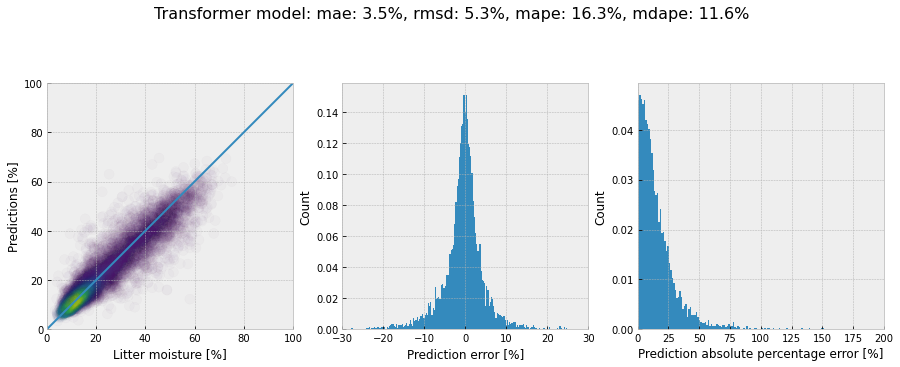

In [19]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"Transformer model: mae: {round(mae, 1)}%, rmsd: {round(rmsd, 1)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.02)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=300, density=True)
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)


error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=300, density=True)
ax[2].set_xlim([0, 200])
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)


plt.savefig("litter_moisture_conv_test_stats2.svg")

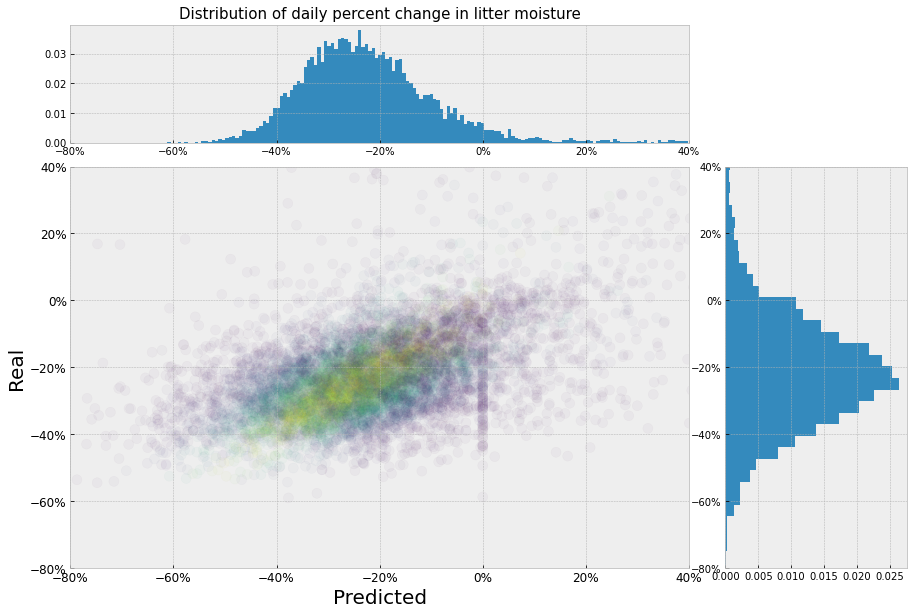

<Figure size 1080x720 with 0 Axes>

In [20]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(pct_change_test, pct_change_predicted, c=z, s=100, alpha=0.03)
ax_hist_x.hist(pct_change_test, orientation="horizontal", bins=150, density=True)
ax_hist_y.hist(pct_change_predicted, bins=500, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_ylabel("Real", fontsize=20)
ax_scatter.set_xlabel("Predicted", fontsize=20)

min_val, max_val = -80, 40
ax_scatter.set_xlim([min_val, max_val])
ax_scatter.set_ylim([min_val, max_val])
ax_hist_y.set_xlim([min_val, max_val])
ax_hist_x.set_ylim([min_val, max_val])
ax_hist_y.set_title(
    "Distribution of daily percent change in litter moisture", fontsize=15
)
ax_scatter.tick_params(axis="both", which="major", labelsize=12)
ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.show()
plt.savefig("results_boundary_pct_change_distribution_conv2.svg")

(-100.0, 150.0)

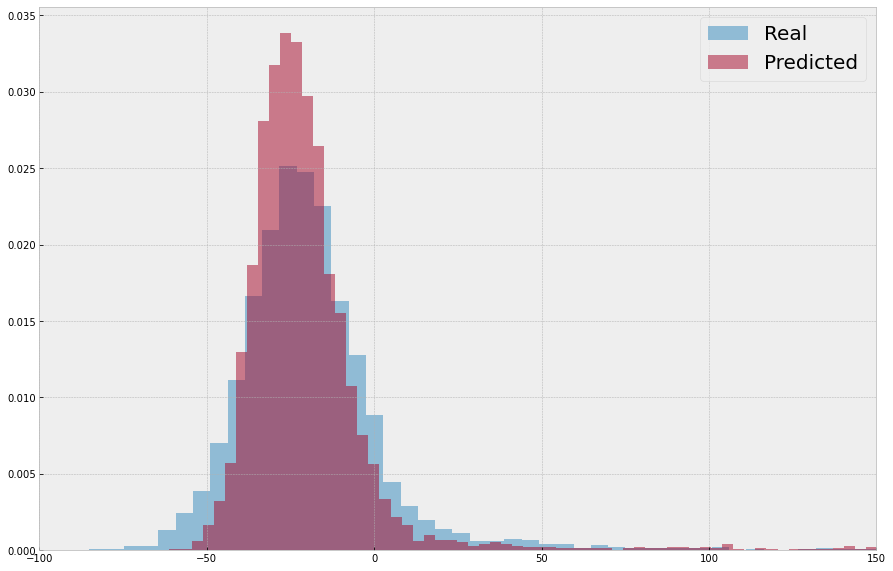

In [21]:
_ = plt.hist(pct_change_test, bins=100, density=True, alpha=0.5, label="Real")
_ = plt.hist(pct_change_predicted, bins=100, density=True, alpha=0.5, label="Predicted")
plt.legend(fontsize=20)
plt.xlim([-100, 150])